In [ ]:

#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import cftime
from tqdm import tqdm
import cmocean as cm
import sys, os
from datetime import datetime

from dask.distributed import Client

In [ ]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 256.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45023,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 256.00 GiB
Comm: tcp://127.0.0.1:42291,Total threads: 1
Dashboard: /proxy/36451/status,Memory: 36.57 GiB
Nanny: tcp://127.0.0.1:39509,


2025-10-21 10:56:04,308 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 79c12d91482bc909f5dcd5c2dc260a56 initialized by task ('rechunk-transfer-46d2ccf0d702a52a61aa76f81fb124f8', 0, 0, 1, 1, 0, 1) executed on worker tcp://127.0.0.1:45155
2025-10-21 10:56:04,424 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 83646bd96067616bb25e8ef566580468 initialized by task ('rechunk-transfer-46d2ccf0d702a52a61aa76f81fb124f8', 0, 0, 0, 1, 0, 0) executed on worker tcp://127.0.0.1:39817
2025-10-21 10:56:04,538 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f0d6acde399ecae9136068d44aa185f3 initialized by task ('rechunk-transfer-46d2ccf0d702a52a61aa76f81fb124f8', 0, 0, 2, 1, 0, 2) executed on worker tcp://127.0.0.1:35029
2025-10-21 10:56:06,572 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 79c12d91482bc909f5dcd5c2dc260a56 deactivated due to stimulus 'task-finished-1761004566.5709019'
2025-10-21 10:56:06,704 - distributed.shuffle._scheduler_plugin - WARN

In [ ]:

time = slice('1982-01-01','2023-12-29')
yt_coord = slice(-77,-65)
xt_coord = slice(-200,-120)

clim_time = slice('1982-01-01','2011-12-31')

import cosima_cookbook as cc
db = 'local_cc_scratch_Ryan_data.db'
session = cc.database.create_session(db)


## Salinity Anomaly

In [ ]:
## Load in the sss data
sss_sample = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='sss', 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          chunks={'time': -1, 'xt_ocean': '400MB', 'yt_ocean': '400MB'}).\
                          sel(time = time).\
                          sel(xt_ocean = xt_coord, yt_ocean = yt_coord).load()


In [ ]:

sss_clim_sample = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='sss', 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          chunks={'time': -1, 'xt_ocean': '400MB', 'yt_ocean': '400MB'}).\
                                                  sel(time = clim_time).\
                          sel(xt_ocean = xt_coord, yt_ocean = yt_coord).load()

In [ ]:
def smoothedClima_mhw(ds):
    """
    Replicate the climatology calculation used in the marineHeatWave.py algorithm.
    Input:
        - ds: xr.Dataset containing (at least) `time` (as np.datetime64 format) and any variable over 
              which the climatology should be calculated (e.g. SST, ice concentration, etc.)
    Output:
        - SmoothThresh: a xr.Dataset of same size as ds, except for the `time` dimension that became a 
        `dayofyear` dimension of size 366. This dataset contains
        
    Note that contrarily to the marineheatwave algorithm, the 366th day is not inserted on 
    the 29th of February via interpolation but is calculated as the other days and is inserted on
    the 31st of December. This subtlety is arising from the handling of dayofyear by xarray (or rather pandas,
    used internally). On leap years, 31st of December is doy 366, while on non-leap years, it is doy 365.
    """
    if ~np.isin("time",ds.dims):
        print("No 'time' dimensions in the dataset")
        return
    # Calculate a rolling mean first, with a 11 days window. 
    ds_rolled = ds.rolling(time=11, min_periods=1, center=True).mean()
    # Calculate the mean over dayofyear
    ds_clim_doy = ds_rolled.groupby("time.dayofyear").mean()
    
    # If I just smooth over that, my beginning and end will be weird.
    # A solution is to replicate 3 times, do the running average, and get the middle year.
    stackedClim = xr.concat([ds_clim_doy,ds_clim_doy,ds_clim_doy],dim='year').stack(time={'year','dayofyear'})
    # Smooth the time series
    smoothedClim = stackedClim.rolling(time=31,
                                       min_periods=1,
                                       center=True).mean()
    # Extract the middle year and rearrange the dimensions to only keep "dayofyear"
    tmpSmooClim = smoothedClim.where(smoothedClim.year==1,drop=True).drop('year')
    ds_smoothedClim = tmpSmooClim.rename({'time':'dayofyear'}).assign_coords(dayofyear=ds_clim_doy.dayofyear.data)
    return ds_smoothedClim


In [ ]:
# Create climatology
sss_clim = smoothedClima_mhw(sss_clim_sample) 

In [ ]:
## Assign time coordinates
sss_clim_daily = sss_clim.sel(dayofyear=sss_sample['time'].dt.dayofyear)
sss_clim_daily = sss_clim_daily.assign_coords(time=sss_sample['time'])
sss_clim_daily

<xarray.DataArray 'sss' (yt_ocean: 114, xt_ocean: 320, time: 15338)> Size: 2GB
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [33.51181 , 33.508434, 33.50504 , ..., 33.5677  , 33.559536,
         33.555054],
        [33.51872 , 33.515324, 33.51194 , ..., 33.572765, 33.564995,
         33.5608  ],
        [33.52622 , 33.52274 , 33.519325, ..., 33.57847 , 33.57111 ,
         33.567204]],

       [[33.418182, 33.41282 , 33.407978, ..., 33.541927, 33.527298,
         33.517475],
        [33.432453, 33.427162, 33.422306, ..., 33.546238, 33.532158,
         33.522907],
        [33.437763, 33.432808, 33.428215, ..., 33.542213, 33.52841 ,
         33.519505],
        ...,
        [33.51958 , 33.516594, 33.513523, ..., 33.575054, 33.56761 ,
         33.563267],
        [33.52906 , 33.5259  , 33.522694, ..., 33.583347, 33.576603,
         33.572704],
        [33.537304, 33.53399 , 33.530678, ..., 33.59135 , 33.585285,
         33.58181 ]]], dtype=float32)
Coordinates:
  * xt_ocean   (xt_ocean) float64 3kB -199.9 -199.6 -199.4 ... -120.4 -120.1
  * yt_ocean   (yt_ocean) float64 912B -76.96 -76.85 -76.75 ... -65.13 -65.03
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...
Attributes:
    long_name:      Practical Salinity
    units:          psu
    valid_range:    [-10. 100.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_salinity
    ncfiles:        ['/g/data/e14/rmh561/access-om2/archive/025deg_jra55_iaf_...
    contact:        Ryan Holmes
    email:          ryan.holmes@unsw.edu.au
    created:        2020-11-03
    description:    0.25 degree ACCESS-OM2 global model configuration under i...

In [ ]:
# Find the SSS anomaly
sss_anom = sss_sample - sss_clim_daily
sss_anom.load()

<xarray.DataArray 'sss' (time: 15338, yt_ocean: 114, xt_ocean: 320)> Size: 2GB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.17499542, -0.19957733, -0.21611023, ..., -0.16114044,
         -0.12275314, -0.06003952],
        [-0.14196396, -0.17098999, -0.19606781, ..., -0.19193268,
         -0.16463852, -0.1186142 ],
        [-0.11078262, -0.13967896, -0.17129517, ..., -0.20324707,
         -0.18357849, -0.15633011]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.42745972,  0.43156815,  0.43860626, ...,  0.06754684,
          0.06424332,  0.06230545],
        [ 0.46909714,  0.4701538 ,  0.47328568, ...,  0.06262589,
          0.0580101 ,  0.05451965],
        [ 0.47828674,  0.48529434,  0.4882965 , ...,  0.05506516,
          0.04685211,  0.04056168]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.4107399 ,  0.42102432,  0.43039322, ...,  0.07238007,
          0.06929779,  0.06764221],
        [ 0.45148468,  0.4591179 ,  0.4635353 , ...,  0.06785583,
          0.0633316 ,  0.05984879],
        [ 0.4593048 ,  0.47678757,  0.48260117, ...,  0.06034851,
          0.05191422,  0.04550171]]], dtype=float32)
Coordinates:
  * xt_ocean   (xt_ocean) float64 3kB -199.9 -199.6 -199.4 ... -120.4 -120.1
  * yt_ocean   (yt_ocean) float64 912B -76.96 -76.85 -76.75 ... -65.13 -65.03
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363

In [ ]:
# Redo coordinates for consistency
sss_anom = sss_anom.rename({'yt_ocean':'lat', 'xt_ocean':'lon'})
sss_anom

<xarray.DataArray 'sss' (time: 15338, lat: 114, lon: 320)> Size: 2GB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.17499542, -0.19957733, -0.21611023, ..., -0.16114044,
         -0.12275314, -0.06003952],
        [-0.14196396, -0.17098999, -0.19606781, ..., -0.19193268,
         -0.16463852, -0.1186142 ],
        [-0.11078262, -0.13967896, -0.17129517, ..., -0.20324707,
         -0.18357849, -0.15633011]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.42745972,  0.43156815,  0.43860626, ...,  0.06754684,
          0.06424332,  0.06230545],
        [ 0.46909714,  0.4701538 ,  0.47328568, ...,  0.06262589,
          0.0580101 ,  0.05451965],
        [ 0.47828674,  0.48529434,  0.4882965 , ...,  0.05506516,
          0.04685211,  0.04056168]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.4107399 ,  0.42102432,  0.43039322, ...,  0.07238007,
          0.06929779,  0.06764221],
        [ 0.45148468,  0.4591179 ,  0.4635353 , ...,  0.06785583,
          0.0633316 ,  0.05984879],
        [ 0.4593048 ,  0.47678757,  0.48260117, ...,  0.06034851,
          0.05191422,  0.04550171]]], dtype=float32)
Coordinates:
  * lon        (lon) float64 3kB -199.9 -199.6 -199.4 ... -120.6 -120.4 -120.1
  * lat        (lat) float64 912B -76.96 -76.85 -76.75 ... -65.24 -65.13 -65.03
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363

In [ ]:
# Load data
sss_anom.load()

<xarray.DataArray 'sss' (time: 15338, lat: 114, lon: 320)> Size: 2GB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.17499542, -0.19957733, -0.21611023, ..., -0.16114044,
         -0.12275314, -0.06003952],
        [-0.14196396, -0.17098999, -0.19606781, ..., -0.19193268,
         -0.16463852, -0.1186142 ],
        [-0.11078262, -0.13967896, -0.17129517, ..., -0.20324707,
         -0.18357849, -0.15633011]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.42745972,  0.43156815,  0.43860626, ...,  0.06754684,
          0.06424332,  0.06230545],
        [ 0.46909714,  0.4701538 ,  0.47328568, ...,  0.06262589,
          0.0580101 ,  0.05451965],
        [ 0.47828674,  0.48529434,  0.4882965 , ...,  0.05506516,
          0.04685211,  0.04056168]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.4107399 ,  0.42102432,  0.43039322, ...,  0.07238007,
          0.06929779,  0.06764221],
        [ 0.45148468,  0.4591179 ,  0.4635353 , ...,  0.06785583,
          0.0633316 ,  0.05984879],
        [ 0.4593048 ,  0.47678757,  0.48260117, ...,  0.06034851,
          0.05191422,  0.04550171]]], dtype=float32)
Coordinates:
  * lon        (lon) float64 3kB -199.9 -199.6 -199.4 ... -120.6 -120.4 -120.1
  * lat        (lat) float64 912B -76.96 -76.85 -76.75 ... -65.24 -65.13 -65.03
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363

## MHW Stats

In [ ]:
# Load in the relevant MHW stats
mhw = xr.open_dataset('/scratch/e14/ts7341/MHW_Statistics_Mask/full_MHW_data_1982_2024_WS.nc')
mhw = mhw.sel(lon = xt_coord, lat = yt_coord)

## Temperature Anomaly

In [ ]:

## CLIMATOLOGIES
pattern = '/g/data/e14/ts7341/Figure_Code_For_Manuscript/Science/JRA_SST_Processed/Climatological_SST/*nc'

import xarray as xr 

def select_sst_only(ds):
    return ds[["sst"]]

Seas = xr.open_mfdataset(
          pattern,
          combine="by_coords",        
          parallel=True,
          preprocess=select_sst_only
).sel(lat = yt_coord, lon = xt_coord)

In [ ]:

print(Seas)

<xarray.Dataset> Size: 53MB
Dimensions:    (lat: 114, lon: 320, dayofyear: 366)
Coordinates:
  * lat        (lat) float64 912B -76.96 -76.85 -76.75 ... -65.24 -65.13 -65.03
  * lon        (lon) float64 3kB -199.9 -199.6 -199.4 ... -120.6 -120.4 -120.1
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Data variables:
    sst        (lat, lon, dayofyear) float32 53MB dask.array<chunksize=(114, 160, 366), meta=np.ndarray>


In [ ]:

## THRESHOLDS
pattern = "/g/data/e14/ts7341/Figure_Code_For_Manuscript/Science/JRA_SST_Processed/90th_Percentile_SST/*.nc"

Thresh = xr.open_mfdataset(
    pattern,
    combine="by_coords",        
    parallel=True,              
)

Thresh = Thresh.sel(lat = yt_coord).sel(lon = xt_coord)

In [ ]:

# Shift 'Thresh' dayofyear from 0-365 to 1-366
Thresh = Thresh.assign_coords(dayofyear=Thresh['dayofyear'] + 1)

In [ ]:
### Load in SST data
ds = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='sst', 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          chunks={'time': -1, 'xt_ocean': '400MB', 'yt_ocean': '400MB'}).\
                          sel(time = time).\
                          sel(yt_ocean = yt_coord).sel(xt_ocean = xt_coord).\
                          load()

In [ ]:

print(ds)

<xarray.DataArray 'sst' (time: 15338, yt_ocean: 114, xt_ocean: 320)> Size: 2GB
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [273.02927, 272.97034, 272.89963, ..., 274.05188, 274.07602,
         274.12866],
        [273.17685, 273.12225, 273.03235, ..., 274.0507 , 274.0945 ,
         274.11475],
        [273.25073, 273.2296 , 273.1607 , ..., 274.04337, 274.12192,
         274.1425 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [272.25952, 272.24292, 272.18762, ..., 273.38803, 273.40652,
         273.40994],
  

In [ ]:
#rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})
# # Rename dimensions
ds = ds.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})

# # Convert surface_temp from Kelvin to Celsius
ds_input = ds - 273.15
ds_input.attrs['units'] = 'deg C'  # Update units attribute

# # Display the modified dataset structure
ds_input = ds_input

In [ ]:
ds_input = ds_input.assign_coords(dayofyear=ds_input['time'].dt.dayofyear)
print(ds_input)

<xarray.DataArray 'sst' (time: 15338, lat: 114, lon: 320)> Size: 2GB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.12072754, -0.17965698, -0.2503662 , ...,  0.901886  ,
          0.9260254 ,  0.9786682 ],
        [ 0.02685547, -0.02774048, -0.11764526, ...,  0.9006958 ,
          0.94451904,  0.9647522 ],
        [ 0.10073853,  0.07962036,  0.01071167, ...,  0.8933716 ,
          0.9719238 ,  0.9924927 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]

In [ ]:
import xarray as xr

Seas_aligned = Seas.interp(
    dayofyear=xr.DataArray(ds_input['dayofyear'].values, dims="time")
)
Thresh_aligned = Thresh.sel(dayofyear=ds_input['dayofyear'])

In [ ]:

Thresh_aligned.__xarray_dataarray_variable__

<xarray.DataArray '__xarray_dataarray_variable__' (lat: 114, lon: 320,
                                                   time: 15338)> Size: 4GB
dask.array<getitem, shape=(114, 320, 15338), dtype=float64, chunksize=(114, 160, 366), chunktype=numpy.ndarray>
Coordinates:
  * lon        (lon) float64 3kB -199.9 -199.6 -199.4 ... -120.6 -120.4 -120.1
  * lat        (lat) float64 912B -76.96 -76.85 -76.75 ... -65.24 -65.13 -65.03
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...

In [ ]:

Seas_aligned = Seas_aligned.sst

In [ ]:

Seas_aligned = Seas.sel(dayofyear=ds_input['dayofyear'])
Seas_aligned = Seas_aligned.sst

In [ ]:

SSTa = ds_input - Seas_aligned

In [ ]:

SSTa = SSTa.chunk({'time':-1,'lon':'300MB','lat':'300MB'})
SSTa = SSTa.load()

In [ ]:

SSTa

<xarray.DataArray 'sst' (time: 15338, lat: 114, lon: 320)> Size: 2GB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.1802085 , -0.2541945 , -0.33143032, ...,  0.31740326,
          0.32587188,  0.36556756],
        [-0.04350158, -0.11453851, -0.21339469, ...,  0.29997462,
          0.32381517,  0.32542902],
        [ 0.0176878 , -0.01859225, -0.09643684, ...,  0.27779377,
          0.33176   ,  0.33081323]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.63335586, -0.6637038 , -0.7238855 , ..., -0.18344629,
         -0.18025506, -0.18963394],
        [-0.62045914, -0.6505674 , -0.71384007, ..., -0.17739978,
         -0.19838732, -0.2200701 ],
        [-0.6084913 , -0.6417775 , -0.6956447 , ..., -0.19169587,
         -0.2223629 , -0.24129832]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.4855846 , -0.5021812 , -0.5607958 , ..., -0.17405343,
         -0.17365143, -0.18335408],
        [-0.47908717, -0.48534408, -0.532234  , ..., -0.17039555,
         -0.19149807, -0.20999622],
        [-0.5012457 , -0.5375166 , -0.5738807 , ..., -0.18308437,
         -0.21140808, -0.22725552]]], dtype=float32)
Coordinates:
  * lon        (lon) float64 3kB -199.9 -199.6 -199.4 ... -120.6 -120.4 -120.1
  * lat        (lat) float64 912B -76.96 -76.85 -76.75 ... -65.24 -65.13 -65.03
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363

In [ ]:
## Find the time series of severity (mentioned in Table 1 of the manuscript)
ts_severity = SSTa/(Thresh_aligned - Seas_aligned)

In [ ]:

ts_severity = ts_severity.__xarray_dataarray_variable__

In [ ]:

ts_severity.load()

<xarray.DataArray '__xarray_dataarray_variable__' (time: 15338, lat: 114,
                                                   lon: 320)> Size: 4GB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.12649805, -0.17625387, -0.22829879, ...,  0.24416449,
          0.25059548,  0.28209763],
        [-0.03060272, -0.07932635, -0.14749455, ...,  0.23273415,
          0.25141634,  0.25412522],
        [ 0.01254392, -0.01291549, -0.06684649, ...,  0.21770652,
          0.26062822,  0.26150926]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.48194279, -0.50032462, -0.54199936, ..., -0.14244146,
         -0.13978083, -0.14765347],
        [-0.4713545 , -0.48652371, -0.53234344, ..., -0.13938107,
         -0.15616836, -0.17411662],
        [-0.46247345, -0.47782461, -0.51742944, ..., -0.15172779,
         -0.1767381 , -0.19267241]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.36269162, -0.37109313, -0.41161348, ..., -0.1349286 ,
         -0.13446674, -0.14258871],
        [-0.35739958, -0.35612671, -0.38929934, ..., -0.13356302,
         -0.15040339, -0.16585072],
        [-0.37449271, -0.39353112, -0.41908471, ..., -0.14459047,
         -0.16775877, -0.18129585]]])
Coordinates:
  * lon        (lon) float64 3kB -199.9 -199.6 -199.4 ... -120.6 -120.4 -120.1
  * lat        (lat) float64 912B -76.96 -76.85 -76.75 ... -65.24 -65.13 -65.03
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...

## SIC

### Original Ice Data

In [ ]:
# Load in sea-ice data
ice = xr.open_mfdataset([#'/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_climatologies/ice_data_for_climatologies/ice_1982-1986.nc',
                         # '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_climatologies/ice_data_for_climatologies/ice_1987-1990.nc',
                         # '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_climatologies/ice_data_for_climatologies/ice_1991-1994.nc',
                         # '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_climatologies/ice_data_for_climatologies/ice_1995-1998.nc',
                         # '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_climatologies/ice_data_for_climatologies/ice_1999-2005.nc',
                         # '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_climatologies/ice_data_for_climatologies/ice_2006-2011.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1982_1988.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1989_1996.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1997_2004.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2005_2011.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2012_2015.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2016-2022.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2023.nc'])
ice_new = xr.open_mfdataset(#'/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/hi_m_and_congel/ice_1982_1991.nc',
                             #'/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/hi_m_and_congel/ice_1992_2000.nc',
                             #'/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/hi_m_and_congel/ice_2001_2011.nc',
                             '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/hi_m_and_congel/*.nc')

ice_clim = xr.open_mfdataset('/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_climatologies/*.nc')

In [ ]:
# Check ice data
ice

<xarray.Dataset> Size: 165GB
Dimensions:   (time: 15340, yt_ocean: 233, xt_ocean: 1440)
Coordinates:
  * time      (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-31T...
    TLON      (yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(233, 1440), meta=np.ndarray>
    TLAT      (yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(233, 1440), meta=np.ndarray>
    ULON      (yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(233, 1440), meta=np.ndarray>
    ULAT      (yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(233, 1440), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 2kB -81.08 -80.97 -80.87 ... -55.28 -55.14
Data variables:
    frazil    (time, yt_ocean, xt_ocean) float32 21GB dask.array<chunksize=(427, 34, 206), meta=np.ndarray>
    meltt     (time, yt_ocean, xt_ocean) float32 21GB dask.array<chunksize=(427, 34, 206), meta=np.ndarray>
    meltb     (time, yt_ocean, xt_ocean) float32 21GB dask.array<chunksize=(427, 34, 206), meta=np.ndarray>
    dvidtt    (time, yt_ocean, xt_ocean) float32 21GB dask.array<chunksize=(427, 34, 206), meta=np.ndarray>
    daidtt    (time, yt_ocean, xt_ocean) float32 21GB dask.array<chunksize=(427, 34, 206), meta=np.ndarray>
    dvidtd    (time, yt_ocean, xt_ocean) float32 21GB dask.array<chunksize=(427, 34, 206), meta=np.ndarray>
    daidtd    (time, yt_ocean, xt_ocean) float32 21GB dask.array<chunksize=(427, 34, 206), meta=np.ndarray>
    aice      (time, yt_ocean, xt_ocean) float32 21GB dask.array<chunksize=(427, 34, 206), meta=np.ndarray>
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       Los Alamos Sea Ice Model (CICE) Version 5
    comment:      This Year Has 365 days
    comment2:     File written on model date 19820102
    comment3:     seconds elapsed into model date:      0
    conventions:  CF-1.0
    history:      This dataset was created on 2024-12-17 at 23:06:50.7
    io_flavor:    io_netcdf

In [ ]:
# Assign coords
ice = ice.assign_coords(dayofyear=ice['time'].dt.dayofyear).sel(time = slice('1982','2023-12-29'))
ice_new = ice_new.assign_coords(dayofyear=ice_new['time'].dt.dayofyear).sel(time = slice('1982','2023-12-29'))

In [ ]:

ice = ice.sel(yt_ocean = yt_coord, xt_ocean = xt_coord).sel(time = slice('1982', '2023-12-29'))
ice_new = ice_new.sel(yt_ocean = yt_coord, xt_ocean = xt_coord).sel(time = slice('1982', '2023-12-29'))

In [ ]:
# Load in for easiere analyses
ice.load()
ice_new.load()

<xarray.Dataset> Size: 9GB
Dimensions:    (time: 15338, yt_ocean: 114, xt_ocean: 320)
Coordinates:
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...
    TLON       (yt_ocean, xt_ocean) float32 146kB nan nan nan ... 239.6 239.9
    TLAT       (yt_ocean, xt_ocean) float32 146kB nan nan nan ... -65.03 -65.03
    ULON       (yt_ocean, xt_ocean) float32 146kB nan nan nan ... -120.5 -120.2
    ULAT       (yt_ocean, xt_ocean) float32 146kB nan nan nan ... -64.97 -64.97
  * xt_ocean   (xt_ocean) float64 3kB -199.9 -199.6 -199.4 ... -120.4 -120.1
  * yt_ocean   (yt_ocean) float64 912B -76.96 -76.85 -76.75 ... -65.13 -65.03
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
Data variables:
    congel     (time, yt_ocean, xt_ocean) float32 2GB nan nan nan ... 0.0 0.0
    hi         (time, yt_ocean, xt_ocean) float32 2GB nan nan ... 0.000714
    uvel       (time, yt_ocean, xt_ocean) float32 2GB nan nan nan ... 0.0 0.0
    vvel       (time, yt_ocean, xt_ocean) float32 2GB nan nan nan ... 0.0 0.0
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       Los Alamos Sea Ice Model (CICE) Version 5
    comment:      This Year Has 365 days
    comment2:     File written on model date 19820102
    comment3:     seconds elapsed into model date:      0
    conventions:  CF-1.0
    history:      This dataset was created on 2024-12-17 at 23:06:50.7
    io_flavor:    io_netcdf

In [ ]:
aice = ice.aice ## Select the SIC

In [ ]:
# Assign clim dayofyear
clim = ice_clim.sel(dayofyear=ice['dayofyear'])
clim

<xarray.Dataset> Size: 206GB
Dimensions:    (yt_ocean: 233, xt_ocean: 1440, time: 15338)
Coordinates:
    TLON       (yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(233, 1440), meta=np.ndarray>
    TLAT       (yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(233, 1440), meta=np.ndarray>
    ULON       (yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(233, 1440), meta=np.ndarray>
    ULAT       (yt_ocean, xt_ocean) float32 1MB dask.array<chunksize=(233, 1440), meta=np.ndarray>
  * xt_ocean   (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * yt_ocean   (yt_ocean) float64 2kB -81.08 -80.97 -80.87 ... -55.28 -55.14
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...
Data variables:
    aice       (yt_ocean, xt_ocean, time) float32 21GB dask.array<chunksize=(233, 1440, 366), meta=np.ndarray>
    congel     (yt_ocean, xt_ocean, time) float32 21GB dask.array<chunksize=(233, 1440, 366), meta=np.ndarray>
    daidtd     (yt_ocean, xt_ocean, time) float32 21GB dask.array<chunksize=(233, 1440, 366), meta=np.ndarray>
    daidtt     (yt_ocean, xt_ocean, time) float32 21GB dask.array<chunksize=(233, 1440, 366), meta=np.ndarray>
    dvidtd     (yt_ocean, xt_ocean, time) float32 21GB dask.array<chunksize=(233, 1440, 366), meta=np.ndarray>
    dvidtt     (yt_ocean, xt_ocean, time) float32 21GB dask.array<chunksize=(233, 1440, 366), meta=np.ndarray>
    frazil     (yt_ocean, xt_ocean, time) float32 21GB dask.array<chunksize=(233, 1440, 366), meta=np.ndarray>
    hi         (yt_ocean, xt_ocean, time) float32 21GB dask.array<chunksize=(233, 1440, 366), meta=np.ndarray>
    meltb      (yt_ocean, xt_ocean, time) float32 21GB dask.array<chunksize=(233, 1440, 366), meta=np.ndarray>
    meltt      (yt_ocean, xt_ocean, time) float32 21GB dask.array<chunksize=(233, 1440, 366), meta=np.ndarray>

In [ ]:
# Various variables below
anom = ice - clim
anom_new = ice_new - clim

In [ ]:
# Congelation + fraz growth
growth = ice.frazil + ice_new.congel

In [ ]:
# Load in
growth = growth.load()

In [ ]:
# Sea-ice thickness
thick = ice_new.hi.load()

In [ ]:
## Growth anomaly
growth_anom = anom.frazil + anom_new.congel

In [ ]:
# Load in growth anomaly
growth_anom = growth_anom.load()

This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(



In [ ]:
## Rename variables for consistency
hi_anom = anom_new.hi.rename({'yt_ocean':'lat', 'xt_ocean':'lon'}).load()

This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(



In [ ]:


anomaly = anom.aice.rename({'yt_ocean':'lat', 'xt_ocean':'lon'})
anomaly

<xarray.DataArray 'aice' (time: 15338, lat: 114, lon: 320)> Size: 2GB
dask.array<subtract, shape=(15338, 114, 320), dtype=float32, chunksize=(366, 114, 320), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...
  * lon        (lon) float64 3kB -199.9 -199.6 -199.4 ... -120.6 -120.4 -120.1
  * lat        (lat) float64 912B -76.96 -76.85 -76.75 ... -65.24 -65.13 -65.03
    TLON       (lat, lon) float32 146kB nan nan nan nan ... 239.4 239.6 239.9
    TLAT       (lat, lon) float32 146kB nan nan nan nan ... -65.03 -65.03 -65.03
    ULON       (lat, lon) float32 146kB nan nan nan nan ... -120.8 -120.5 -120.2
    ULAT       (lat, lon) float32 146kB nan nan nan nan ... -64.97 -64.97 -64.97
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363

In [ ]:

anomaly.load()

<xarray.DataArray 'aice' (time: 15338, lat: 114, lon: 320)> Size: 2GB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.06863937,  0.0832189 ,  0.08821061, ..., -0.12161245,
         -0.1218978 , -0.12274737],
        [ 0.0309138 ,  0.04508042,  0.05569176, ..., -0.1108315 ,
         -0.1115097 , -0.11233412],
        [-0.00696398,  0.00025326,  0.01183739, ..., -0.10178979,
         -0.1026281 , -0.10329577]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 0.09433085,  0.13353986,  0.1673826 , ..., -0.15704454,
         -0.15601403, -0.1558057 ],
        [-0.03005423,  0.00278381,  0.03977031, ..., -0.14811687,
         -0.14682466, -0.14632578],
        [-0.13964029, -0.12229954, -0.09416609, ..., -0.14029905,
         -0.13881373, -0.13834889]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.01506597,  0.01000345,  0.04120329, ..., -0.15573275,
         -0.15475826, -0.15462403],
        [-0.12591246, -0.11049566, -0.07668631, ..., -0.1468468 ,
         -0.14560895, -0.1451786 ],
        [-0.18295455, -0.17838235, -0.16024776, ..., -0.13903438,
         -0.13757053, -0.13714564]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...
  * lon        (lon) float64 3kB -199.9 -199.6 -199.4 ... -120.6 -120.4 -120.1
  * lat        (lat) float64 912B -76.96 -76.85 -76.75 ... -65.24 -65.13 -65.03
    TLON       (lat, lon) float32 146kB nan nan nan nan ... 239.4 239.6 239.9
    TLAT       (lat, lon) float32 146kB nan nan nan nan ... -65.03 -65.03 -65.03
    ULON       (lat, lon) float32 146kB nan nan nan nan ... -120.8 -120.5 -120.2
    ULAT       (lat, lon) float32 146kB nan nan nan nan ... -64.97 -64.97 -64.97
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363

In [ ]:

anomaly_dvidtt = anom.dvidtt
anomaly_dvidtt.load()

<xarray.DataArray 'dvidtt' (time: 15338, yt_ocean: 114, xt_ocean: 320)> Size: 2GB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.20254433,  0.13036942,  0.10788178, ...,  0.1975646 ,
          0.23640385,  0.24953175],
        [ 0.3240565 ,  0.2790135 ,  0.24580038, ...,  0.0954209 ,
          0.15712771,  0.18972972],
        [ 0.43912405,  0.4475733 ,  0.42187595, ..., -0.00711274,
          0.06666493,  0.11480179]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.1713711 , -0.31190956, -0.424801  , ...,  0.6465171 ,
          0.64146006,  0.6341708 ],
        [ 0.37159216,  0.24958146,  0.12440991, ...,  0.6299488 ,
          0.624118  ,  0.6159018 ],
        [ 0.8685826 ,  0.7926822 ,  0.67573684, ...,  0.60622406,
          0.5999331 ,  0.5939354 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.09592056, -0.02386808, -0.16454768, ...,  0.6470662 ,
          0.6418998 ,  0.63440293],
        [ 0.6631921 ,  0.5816803 ,  0.41289723, ...,  0.6301998 ,
          0.62424934,  0.61598223],
        [ 1.0159858 ,  0.99770004,  0.88695794, ...,  0.6071308 ,
          0.600715  ,  0.5945848 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...
  * xt_ocean   (xt_ocean) float64 3kB -199.9 -199.6 -199.4 ... -120.4 -120.1
  * yt_ocean   (yt_ocean) float64 912B -76.96 -76.85 -76.75 ... -65.13 -65.03
    TLON       (yt_ocean, xt_ocean) float32 146kB nan nan nan ... 239.6 239.9
    TLAT       (yt_ocean, xt_ocean) float32 146kB nan nan nan ... -65.03 -65.03
    ULON       (yt_ocean, xt_ocean) float32 146kB nan nan nan ... -120.5 -120.2
    ULAT       (yt_ocean, xt_ocean) float32 146kB nan nan nan ... -64.97 -64.97
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363

## Unused Analyses – trying to find trends in variables


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Choose which correlation map to plot – These are not used
correlation_map_computed = corr_sig  # or corr_map if you want all correlations

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-25))

# Add coastlines and gridlines
ax.coastlines()
ax.add_feature(cfeature.LAND, zorder=1, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='white')
gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5)
gl.xlabels_top = False
gl.ylabels_right = False

# Plot correlation map
correlation_map_computed.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    vmin=-1, vmax=1,
    cbar_kwargs={
        'label': 'Spearman Correlation (Nov15-Dec31 SSS vs Next Jan-Apr MHW Days)',
        'shrink': 0.7
    }
)

# Add title
ax.set_title('Link between Autumn SSS Anomaly and Winter Marine Heatwaves', pad=20)

plt.show()


Pearson correlation: 0.03, p-value: 0.898


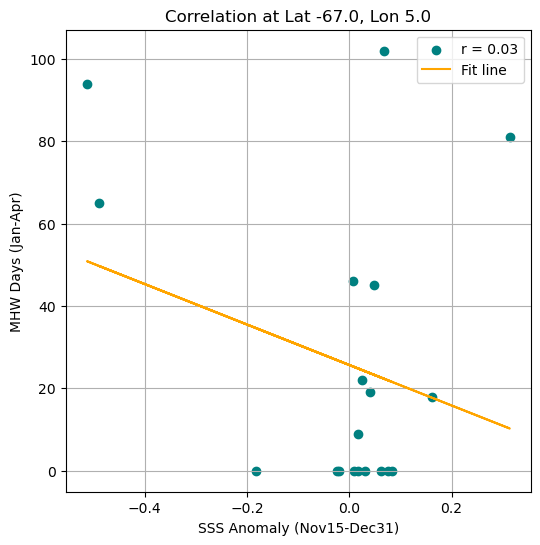

In [ ]:
lat_sel = -67.0  # example latitude
lon_sel = 5.0  # example longitude

sss_point = sss_anom.sel(lat=lat_sel, lon=lon_sel, method='nearest')
ts_point = ts_severity.sel(lat=lat_sel, lon=lon_sel, method='nearest')

years = np.arange(2005, 2024)
sss_yearly = []
mhw_days_yearly = []

for year in years:
    # SSS anomaly Nov15-Dec31
    sss_nd = sss_point.sel(time=slice(f'{year}-11-15', f'{year}-12-31')).mean().values
    sss_yearly.append(sss_nd)
    
    # MHW days Jan-Apr (next year)
    ts_jfma = ts_point.sel(time=slice(f'{year+1}-01-01', f'{year+1}-04-30'))
    mhw_days = (ts_jfma > 1).sum().values
    mhw_days_yearly.append(mhw_days)

import scipy.stats as stats

# Compute correlation
corr, pval = stats.spearmanr(sss_yearly, mhw_days_yearly)
print(f'Pearson correlation: {corr:.2f}, p-value: {pval:.3f}')

# Optional: plot scatter with regression line
plt.figure(figsize=(6,6))
plt.scatter(sss_yearly, mhw_days_yearly, color='teal', label=f'r = {corr:.2f}')
m, b = np.polyfit(sss_yearly, mhw_days_yearly, 1)
plt.plot(sss_yearly, m*np.array(sss_yearly)+b, color='orange', label='Fit line')
plt.xlabel('SSS Anomaly (Nov15-Dec31)')
plt.ylabel('MHW Days (Jan-Apr)')
plt.title(f'Correlation at Lat {lat_sel}, Lon {lon_sel}')
plt.legend()
plt.grid(True)
plt.show()


## Scatterplots – Nearly all of this code is unused, except for Fig 10, two cells from the bottom of this notebook!

In [ ]:
# This cell executes: anom_ice = anomaly.mean(['lon','lat'])
anom_ice = anomaly.mean(['lon','lat'])
aice = ice.aice.mean(['xt_ocean','yt_ocean'])
thickness_anom = hi_anom.mean(['lon','lat'])
ssta = SSTa.mean(['lon','lat'])
ts_sev_mean = ts_severity.mean(['lon','lat'])
sss_anoms = sss_anom.mean(['lon','lat'])

In [ ]:
# This cell executes: 
# anomaly = anomaly.sel(lon = slice(-90,-60)).sel(lat = slice(-70,-63))
# ts_severity = ts_severity.sel(lon = slice(-90,-60)).sel(lat = slice(-70,-63))
# ssta = SSTa.sel(lon = slice(-90,-60)).sel(lat = slice(-70,-63))
# hi_anom = hi_anom.sel(lon = slice(-90,-60)).sel(lat = slice(-70,-63))

In [ ]:

ts_severity_sss = ts_severity_sss.sel(lat=slice(-70,-63))

In [ ]:
# Grid area
area = cc.querying.getvar(
    expt='025deg_jra55_iaf_cycle6_online_mlt',
    variable='area_t', 
    session=session,
    frequency='static',
    attrs={'cell_methods': 'time: point'},
    n=1
)
areas = area.sel(yt_ocean=yt_coord, xt_ocean = xt_coord).load()

In [ ]:
# Grid area
area = area.load()

Points before IQR: 410, after IQR clipping: 409


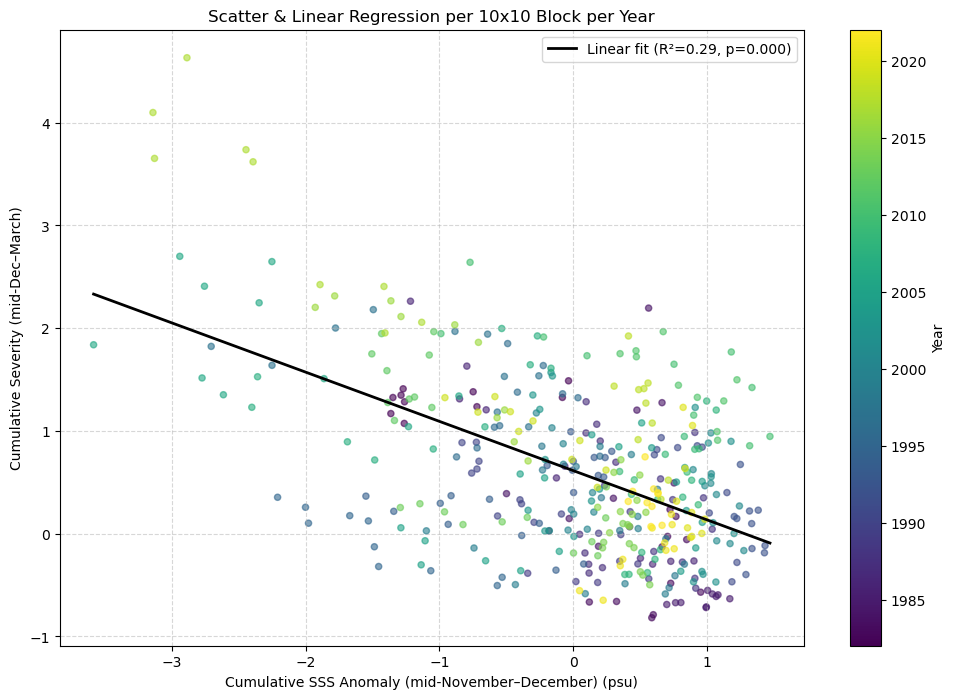

Linear Regression Results (After IQR outlier removal):
Slope: -0.4789
Intercept: 0.6146
R²: 0.2916
p-value: 2.4883e-32
Spearman rho: -0.4134, p-value: 2.5893e-18


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# -----------------------------
# Parameters
# -----------------------------
years = np.arange(1982, 2023)
block_size_lat = 10  # block size in latitude
block_size_lon = 10  # block size in longitude

# -----------------------------
# Robust area-weighted block averaging function
# -----------------------------
def block_average_area_weighted(arr, area, block_size_lat, block_size_lon):
    """
    Compute area-weighted block averages of a 2D array.
    Handles NaNs and blocks with zero total weight.
    """
    arr = np.array(arr)
    weights = np.array(area)
    
    n_lat, n_lon = arr.shape
    n_blocks_lat = int(np.ceil(n_lat / block_size_lat))
    n_blocks_lon = int(np.ceil(n_lon / block_size_lon))

    result = np.full((n_blocks_lat, n_blocks_lon), np.nan)

    for i in range(n_blocks_lat):
        for j in range(n_blocks_lon):
            # Define block slices
            lat_start = i * block_size_lat
            lat_end = min((i + 1) * block_size_lat, n_lat)
            lon_start = j * block_size_lon
            lon_end = min((j + 1) * block_size_lon, n_lon)

            arr_block = arr[lat_start:lat_end, lon_start:lon_end]
            weights_block = weights[lat_start:lat_end, lon_start:lon_end]

            # Mask NaNs
            valid_mask = ~np.isnan(arr_block) & ~np.isnan(weights_block)
            if np.any(valid_mask):
                weighted_sum = np.sum(arr_block[valid_mask] * weights_block[valid_mask])
                total_weight = np.sum(weights_block[valid_mask])
                if total_weight > 0:
                    result[i, j] = weighted_sum / total_weight
    return result

# -----------------------------
# Collect block-averaged values
# -----------------------------
x_list, y_list, year_list = [], [], []

for yr in years:
    # Select time slices
    sic = ts_severity_sss.sel(time=slice(f"{yr}-11-15", f"{yr}-12-01")).mean(dim="time").values
    severity = ts_severity.sel(time=slice(f"{yr}-12-01", f"{yr}-12-31")).max(dim="time").values

    # Debug: check shapes and NaNs
    #rint(f"{yr}: SIC shape {sic.shape}, NaNs {np.isnan(sic).sum()} | Severity shape {severity.shape}, NaNs {np.isnan(severity).sum()}")

    if sic.size == 0 or severity.size == 0:
        print(f"Skipping year {yr} due to empty data")
        continue

    # Block average
    sic_block = block_average_area_weighted(sic, area, block_size_lat, block_size_lon)
    severity_block = block_average_area_weighted(severity, area, block_size_lat, block_size_lon)

    # Flatten and append
    x_list.append(sic_block.flatten())
    y_list.append(severity_block.flatten())
    year_list.append(np.full(sic_block.size, yr))

# Stack all years
x = np.concatenate(x_list)
y = np.concatenate(y_list)
years_flat = np.concatenate(year_list)

# Remove NaNs
mask = (~np.isnan(x)) & (~np.isnan(y))
x, y, years_flat = x[mask], y[mask], years_flat[mask]


if len(x) == 0:
    raise ValueError("No valid data points after removing NaNs. Check input arrays.")

# -----------------------------
# Outlier removal using IQR (robust)
# -----------------------------
q25_x, q75_x = np.percentile(x, [25, 75])
iqr_x = q75_x - q25_x
q25_y, q75_y = np.percentile(y, [25, 75])
iqr_y = q75_y - q25_y

thresh = 3  # can increase if too strict
mask_iqr = ((x >= q25_x - thresh*iqr_x) & (x <= q75_x + thresh*iqr_x) &
            (y >= q25_y - thresh*iqr_y) & (y <= q75_y + thresh*iqr_y))

x_clean = x[mask_iqr]
y_clean = y[mask_iqr]
years_clean = years_flat[mask_iqr]

print(f"Points before IQR: {len(x)}, after IQR clipping: {len(x_clean)}")
if len(x_clean) == 0:
    raise ValueError("No points left after IQR outlier removal. Try increasing 'thresh'.")

# -----------------------------
# Linear regression + Spearman correlation
# -----------------------------
slope, intercept, r_value, p_value, std_err = linregress(x_clean, y_clean)
rho, rho_p = spearmanr(x_clean, y_clean)
x_fit = np.linspace(x_clean.min(), x_clean.max(), 200)
y_fit = slope * x_fit + intercept

# -----------------------------
# Scatter plot colored by year
# -----------------------------
norm = mcolors.Normalize(vmin=years[0], vmax=years[-1])
cmap = cm.viridis
colors = cmap(norm(years_clean))

fig, ax = plt.subplots(figsize=(12,8))
sc = ax.scatter(x_clean, y_clean, alpha=0.6, s=20, color=colors)
ax.plot(x_fit, y_fit, color="black", lw=2,
        label=f"Linear fit (R²={r_value**2:.2f}, p={p_value:.3f})")
ax.set_xlabel("Cumulative SSS Anomaly (mid-November–December) (psu)")
ax.set_ylabel("Cumulative Severity (mid-Dec–March)")
ax.set_title(f"Scatter & Linear Regression per {block_size_lat}x{block_size_lon} Block per Year")
ax.grid(ls="--", alpha=0.5)
ax.legend()

# Colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Year')

plt.show()

# -----------------------------
# Print regression results
# -----------------------------
print("Linear Regression Results (After IQR outlier removal):")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R²: {r_value**2:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Spearman rho: {rho:.4f}, p-value: {rho_p:.4e}")


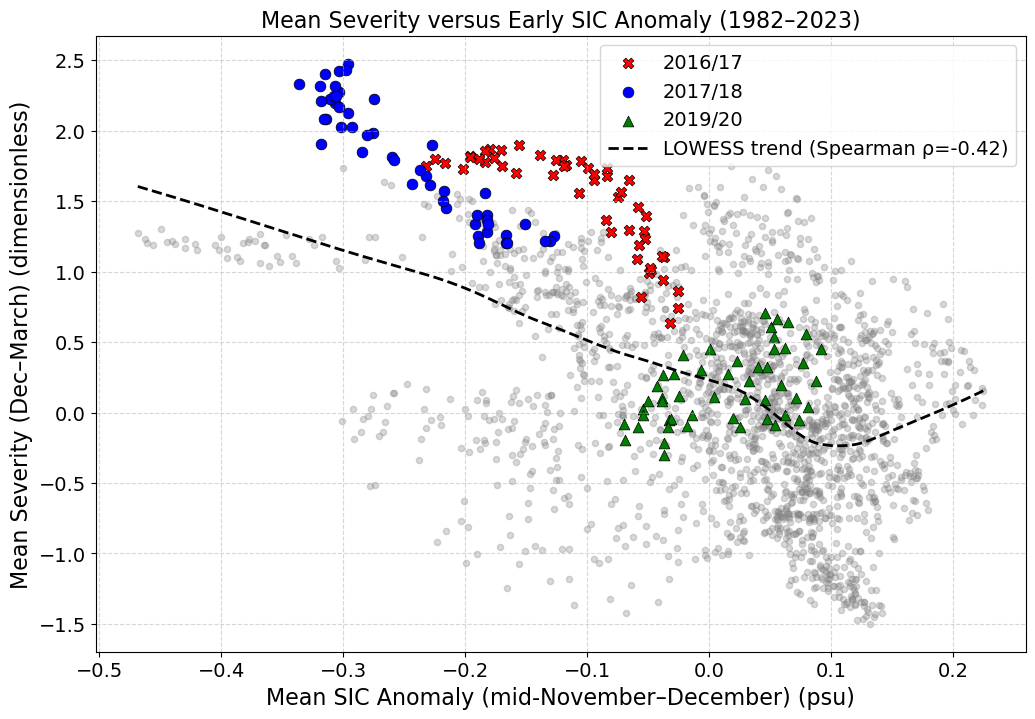

Spearman correlation: ρ = -0.4215, p-value = 4.1646e-89


In [ ]:
# This cell executes: import matplotlib.cm as cm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import statsmodels.api as sm
from scipy.stats import spearmanr

# -----------------------------
# LOWESS smoothing
# -----------------------------
lowess = sm.nonparametric.lowess(y_clean, x_clean, frac=0.5)
x_lowess, y_lowess = lowess[:, 0], lowess[:, 1]

# -----------------------------
# Spearman correlation
# -----------------------------
rho, rho_p = spearmanr(x_clean, y_clean)

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(12,8))

# Masks for special years 

mask_2017 = years_clean == 2016
mask_2018 = years_clean == 2017
mask_2020 = years_clean == 2019
mask_normal = ~(mask_2017 | mask_2018 | mask_2020)

# Plot all other years (grey dots)
ax.scatter(x_clean[mask_normal], y_clean[mask_normal],
           alpha=0.3, s=20, color="grey")

# Highlight 2017 with X (red)
ax.scatter(x_clean[mask_2017], y_clean[mask_2017],
           color="red", s=60, marker='X',
           edgecolors='black', linewidths=0.5, label='2016/17')

# Highlight 2018 with circle (blue)
ax.scatter(x_clean[mask_2018], y_clean[mask_2018],
           color="blue", s=60, marker='o',
           edgecolors='black', linewidths=0.5, label='2017/18')

# Highlight 2020 with triangle (green)
ax.scatter(x_clean[mask_2020], y_clean[mask_2020],
           color="green", s=60, marker='^',
           edgecolors='black', linewidths=0.5, label='2019/20')

# LOWESS trend
ax.plot(x_lowess, y_lowess, color="black", lw=2, ls="--",
        label=f"LOWESS trend (Spearman ρ={rho:.2f})")

# Labels & title
ax.set_xlabel("Mean SIC Anomaly (mid-November–December) (psu)", fontsize=16)
ax.set_ylabel("Mean Severity (Dec–March) (dimensionless)", fontsize=16)
ax.set_title("Mean Severity versus Early SIC Anomaly (1982–2023)", fontsize=16)

# Tick size
ax.tick_params(axis='both', which='major', labelsize=14)

# Grid and legend
ax.grid(ls="--", alpha=0.5)
ax.legend(fontsize=14)

plt.show()

# -----------------------------
# Print Spearman result
# -----------------------------
print(f"Spearman correlation: ρ = {rho:.4f}, p-value = {rho_p:.4e}")


In [ ]:
# This cell executes: mhw
mhw

<xarray.Dataset> Size: 96MB
Dimensions:          (lat: 66, lon: 320, event: 57)
Coordinates:
  * lon              (lon) float64 3kB -59.88 -59.62 -59.38 ... 19.62 19.88
  * lat              (lat) float64 528B -69.99 -69.88 -69.78 ... -63.17 -63.06
  * event            (event) int64 456B 0 1 2 3 4 5 6 7 ... 50 51 52 53 54 55 56
Data variables:
    index_start      (lat, lon, event) float64 10MB ...
    index_end        (lat, lon, event) float64 10MB ...
    date_start       (lat, lon, event) datetime64[ns] 10MB 1985-10-31T12:00:0...
    date_end         (lat, lon, event) datetime64[ns] 10MB 1985-12-13T12:00:0...
    duration         (lat, lon, event) float64 10MB ...
    n_event          (lat, lon) int64 169kB ...
    index_peak       (lat, lon, event) float64 10MB ...
    date_peak        (lat, lon, event) datetime64[ns] 10MB ...
    intensity_max    (lat, lon, event) float64 10MB ...
    intensity_mean   (lat, lon, event) float64 10MB ...
    intensity_cumul  (lat, lon, event) float64 10MB ...

In [ ]:
# This cell executes: area = area.sel(xt_ocean = xt_coord, yt_ocean = slice(-77,-73)).load()
area = area.sel(xt_ocean = xt_coord, yt_ocean = slice(-77,-73)).load()

In [ ]:
# This cell executes: ts_severity
ts_severity

<xarray.DataArray '__xarray_dataarray_variable__' (time: 15338, lat: 66,
                                                   lon: 280)> Size: 2GB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ..., -0.45598445,
         -0.43320549, -0.41931423],
        [        nan,         nan,         nan, ..., -0.48197289,
         -0.46420636, -0.44387624],
        [        nan,         nan,  0.26658475, ..., -0.49583108,
         -0.48692413, -0.46900531]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ..., -0.09669056,
         -0.16659066, -0.21275698],
        [        nan,         nan,         nan, ...,  0.08472836,
          0.00284142, -0.05521378],
        [        nan,         nan, -0.57805593, ...,  0.27845679,
          0.19119675,  0.12807548]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ..., -0.30971506,
         -0.34713695, -0.37501935],
        [        nan,         nan,         nan, ..., -0.1944499 ,
         -0.24688857, -0.28718836],
        [        nan,         nan, -0.63223771, ..., -0.03723036,
         -0.09473011, -0.13744804]]])
Coordinates:
  * lon        (lon) float64 2kB -199.9 -199.6 -199.4 ... -130.6 -130.4 -130.1
  * lat        (lat) float64 528B -76.96 -76.85 -76.75 ... -70.31 -70.2 -70.09
    dayofyear  (time) int64 123kB 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * time       (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 2023-12-29...

Points before outlier removal: 112, after IQR clipping: 112


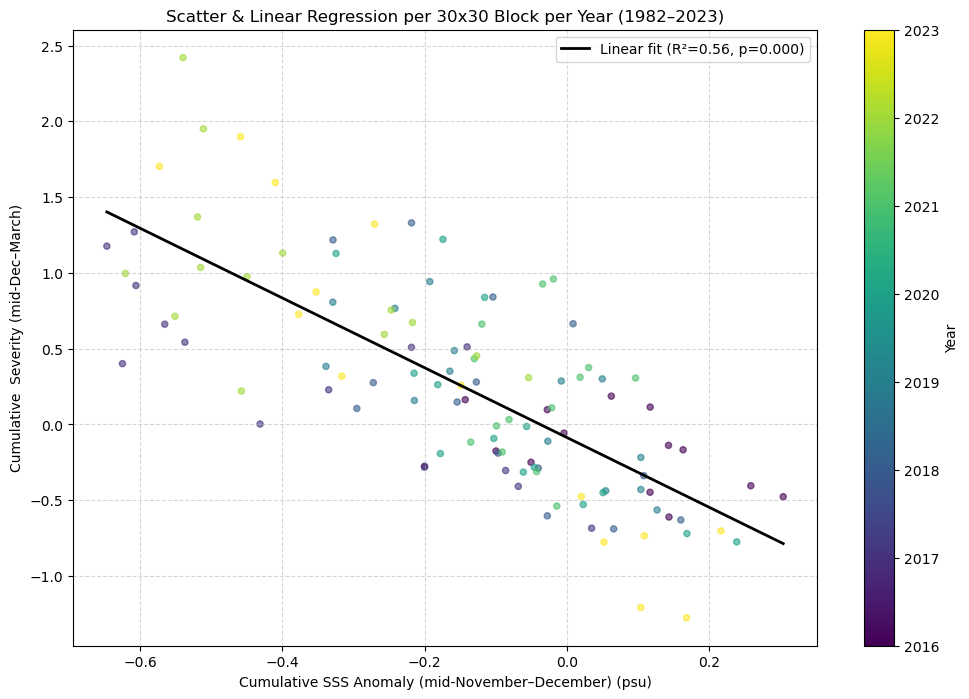

Linear Regression Results (After IQR outlier removal):
Slope: -2.2995
Intercept: -0.0857
R²: 0.5599
p-value: 2.4999e-21
Spearman rho: -0.7663, p-value: 7.1373e-23


In [ ]:
# This cell executes: import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# -----------------------------
# Parameters
# -----------------------------
block_size_lat = 30
block_size_lon = 30
years = np.arange(2016, 2024)

# -----------------------------
# Area-weighted block averaging function
# -----------------------------
import numpy as np

def block_average_area_weighted_robust(arr, area, block_size_lat, block_size_lon):
    """
    Calculates a robust, NaN-safe, area-weighted block average.
    """
    arr = np.array(arr)
    weights = np.array(area)
    
    # --- Critical Check ---
    if arr.shape != weights.shape:
        raise ValueError("The shape of the data array and the area array must be identical.")

    n_lat, n_lon = arr.shape
    n_blocks_lat = int(np.ceil(n_lat / block_size_lat))
    n_blocks_lon = int(np.ceil(n_lon / block_size_lon))

    result = np.full((n_blocks_lat, n_blocks_lon), np.nan) # Initialize with NaNs

    for i in range(n_blocks_lat):
        for j in range(n_blocks_lon):
            lat_start = i * block_size_lat
            lat_end = min((i + 1) * block_size_lat, n_lat)
            lon_start = j * block_size_lon
            lon_end = min((j + 1) * block_size_lon, n_lon)

            arr_block = arr[lat_start:lat_end, lon_start:lon_end]
            weights_block = weights[lat_start:lat_end, lon_start:lon_end]
            
            # --- NaN-Handling Logic ---
            # Create a mask of valid (not-NaN) data points in the block
            valid_mask = ~np.isnan(arr_block)

            # If there are no valid data points in the block, the result is NaN (already set)
            if not np.any(valid_mask):
                continue

            # Sum only the valid data points, weighted by their corresponding area
            weighted_sum = np.sum(arr_block[valid_mask] * weights_block[valid_mask])
            
            # Sum only the weights of the valid data points
            total_weight = np.sum(weights_block[valid_mask])

            if total_weight > 0:
                result[i, j] = weighted_sum / total_weight

    return result

# -----------------------------
# Collect block-averaged values
# -----------------------------
x_list, y_list, year_list = [], [], []

lats = ts_severity['lat'].values  # Assuming your dataset has latitudes

for yr in years:
    severity = ts_severity.sel(time=slice(f"{yr}-01-01", f"{yr}-02-28")).mean(dim="time").values
    sic = anomaly.sel(time=slice(f"{yr}-03-01", f"{yr}-03-31")).mean(dim="time").values

    severity_block = block_average_area_weighted_robust(severity, areas, block_size_lat, block_size_lon)
    sic_block = block_average_area_weighted_robust(sic, areas, block_size_lat, block_size_lon)

    # Flatten and append
    x_list.append(sic_block.flatten())       # Predictor
    y_list.append(severity_block.flatten())  # Response
    year_list.append(np.full(sic_block.size, yr))

# Stack all years
x = np.concatenate(x_list)  # SIC anomaly
y = np.concatenate(y_list)  # Severity
years_flat = np.concatenate(year_list)

# Remove NaNs
mask = (~np.isnan(x)) & (~np.isnan(y))
x, y, years_flat = x[mask], y[mask], years_flat[mask]

if len(x) == 0 or len(y) == 0:
    raise ValueError("No valid data points left after masking NaNs. Check your input arrays.")

# -----------------------------
# Outlier removal using IQR (robust)
# -----------------------------
q25_x, q75_x = np.percentile(x, [25, 75])
iqr_x = q75_x - q25_x
q25_y, q75_y = np.percentile(y, [25, 75])
iqr_y = q75_y - q25_y
thresh = 3

mask_iqr = ((x >= q25_x - thresh*iqr_x) & (x <= q75_x + thresh*iqr_x) &
            (y >= q25_y - thresh*iqr_y) & (y <= q75_y + thresh*iqr_y))

x_clean = x[mask_iqr]
y_clean = y[mask_iqr]
years_clean = years_flat[mask_iqr]

print(f"Points before outlier removal: {len(x)}, after IQR clipping: {len(x_clean)}")

# -----------------------------
# Linear regression + Spearman correlation
# -----------------------------
slope, intercept, r_value, p_value, std_err = linregress(x_clean, y_clean)
rho, rho_p = spearmanr(x_clean, y_clean)

x_fit = np.linspace(x_clean.min(), x_clean.max(), 200)
y_fit = slope * x_fit + intercept

# -----------------------------
# Scatter plot colored by year
# -----------------------------
norm = mcolors.Normalize(vmin=years[0], vmax=years[-1])
cmap = cm.viridis
colors = cmap(norm(years_clean))

fig, ax = plt.subplots(figsize=(12,8))
sc = ax.scatter(x_clean, y_clean, alpha=0.6, s=20, color=colors)  # SIC on x, severity on y
ax.plot(x_fit, y_fit, color="black", lw=2,
        label=f"Linear fit (R²={r_value**2:.2f}, p={p_value:.3f})")
ax.set_xlabel("Cumulative SSS Anomaly (mid-November–December) (psu)")
ax.set_ylabel("Cumulative  Severity (mid-Dec–March)")
ax.set_title(f"Scatter & Linear Regression per {block_size_lat}x{block_size_lon} Block per Year (1982–2023)")
ax.grid(ls="--", alpha=0.5)
ax.legend()

# Colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Year')

plt.show()

# -----------------------------
# Print regression results
# -----------------------------
print("Linear Regression Results (After IQR outlier removal):")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R²: {r_value**2:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Spearman rho: {rho:.4f}, p-value: {rho_p:.4e}")


In [ ]:
# This cell executes: import xarray as xr
import xarray as xr
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --------------------------------------------------------
# 1. Load your datasets
# SSTa and anomaly: time x lat x lon
# --------------------------------------------------------
# SSTa = xr.open_dataarray("sst_anomaly.nc")
# anomaly = xr.open_dataarray("sea_ice_anomaly.nc")

# --------------------------------------------------------
# 2. Select predictor and response months
# Predictor: Jan–Feb (1,2)
# Response: Mar–Apr (3,4)
# --------------------------------------------------------
sst_sel = SSTa.sel(time=SSTa.time.dt.month.isin([1, 2]))
ice_sel = anomaly.sel(time=anomaly.time.dt.month.isin([3]))

# Average over selected months
sst_mean = sst_sel.groupby("time.year").mean(dim="time")
ice_mean = ice_sel.groupby("time.year").mean(dim="time")

# --------------------------------------------------------
# 3. Prepare arrays for regression results
# --------------------------------------------------------
lat_len = SSTa.shape[1]
lon_len = SSTa.shape[2]

slopes = np.full((lat_len, lon_len), np.nan)
pvals  = np.full((lat_len, lon_len), np.nan)

# --------------------------------------------------------
# 4. Loop over grid cells
# --------------------------------------------------------
years = sst_mean.year.values  # ensure same length

for i in range(lat_len):
    for j in range(lon_len):
        sst_cell = sst_mean.isel(lat=i, lon=j).values
        ice_cell = ice_mean.isel(lat=i, lon=j).values

        # Skip if NaNs
        if np.all(np.isnan(sst_cell)) or np.all(np.isnan(ice_cell)):
            continue

        # Align time series
        mask = ~np.isnan(sst_cell) & ~np.isnan(ice_cell)
        if np.sum(mask) < 2:
            continue

        X_clean = sst_cell[mask].reshape(-1, 1)
        y_clean = ice_cell[mask]

        # Add intercept
        X_const = sm.add_constant(X_clean)

        # Fit regression
        model = sm.OLS(y_clean, X_const).fit()

        # Store results
        slopes[i, j] = model.params[1]
        pvals[i, j]  = model.pvalues[1]

# --------------------------------------------------------
# 5. Convert to xarray for mapping
# --------------------------------------------------------
slope_map = xr.DataArray(slopes, coords=[SSTa.lat, SSTa.lon], dims=["lat", "lon"])
pval_map  = xr.DataArray(pvals, coords=[SSTa.lat, SSTa.lon], dims=["lat", "lon"])
significant_map = slope_map.where(pval_map < 0.05)

# --------------------------------------------------------
# 6. Plot significant regression slopes
# --------------------------------------------------------
plt.figure(figsize=(10,5))
significant_map.plot(cmap="coolwarm", center=0)
plt.title("Lagged regression slope (Jan–Feb SST → Mar–Apr sea ice anomaly), p<0.05")
plt.show()



In [ ]:
import numpy as np

# Thresholds for "high" melt and "high" severity
x_thresh = np.percentile(x_clean, 90)  # top 10% SSS anomaly
y_thresh = np.percentile(y_clean, 90)  # top 10% severity

# Mask for points that exceed both thresholds
high_mask = (x_clean >= x_thresh) & (y_clean >= y_thresh)

# Get the corresponding years and coordinates
high_years = years_clean[high_mask]
high_x = x_clean[high_mask]
high_y = y_clean[high_mask]

print("High melt & high severity years:")
for yr, xx, yy in zip(high_years, high_x, high_y):
    print(f"Year {yr}: x={xx:.2f}, y={yy:.2f}")


High melt & high severity years:
Year 1990: x=4.38, y=274.35
Year 1990: x=4.62, y=262.39
Year 2002: x=5.68, y=106.78
Year 2003: x=4.29, y=113.39
Year 2003: x=5.41, y=120.99
Year 2011: x=5.77, y=206.18
Year 2011: x=5.14, y=140.54
Year 2011: x=4.35, y=221.03
Year 2011: x=6.33, y=237.47
Year 2011: x=3.97, y=155.87


In [ ]:
## Data very specifically selected for the code just two blocks down
anom_plot = anomaly.sel(lat = slice(-77,-70)).load()
sev_plot = ts_severity.sel(lat = slice(-77,-70)).load()
SSTas = SSTa.sel(lat = slice(-77,-70)).load()

In [ ]:
# Proper grid area for the code
area = cc.querying.getvar(
    expt='025deg_jra55_iaf_cycle6_online_mlt',
    variable='area_t', 
    session=session,
    frequency='static',
    attrs={'cell_methods': 'time: point'},
    n=1
)
areas = area.sel(yt_ocean=yt_coord, xt_ocean = xt_coord).load()

Points before outlier removal: 462, after IQR clipping: 462


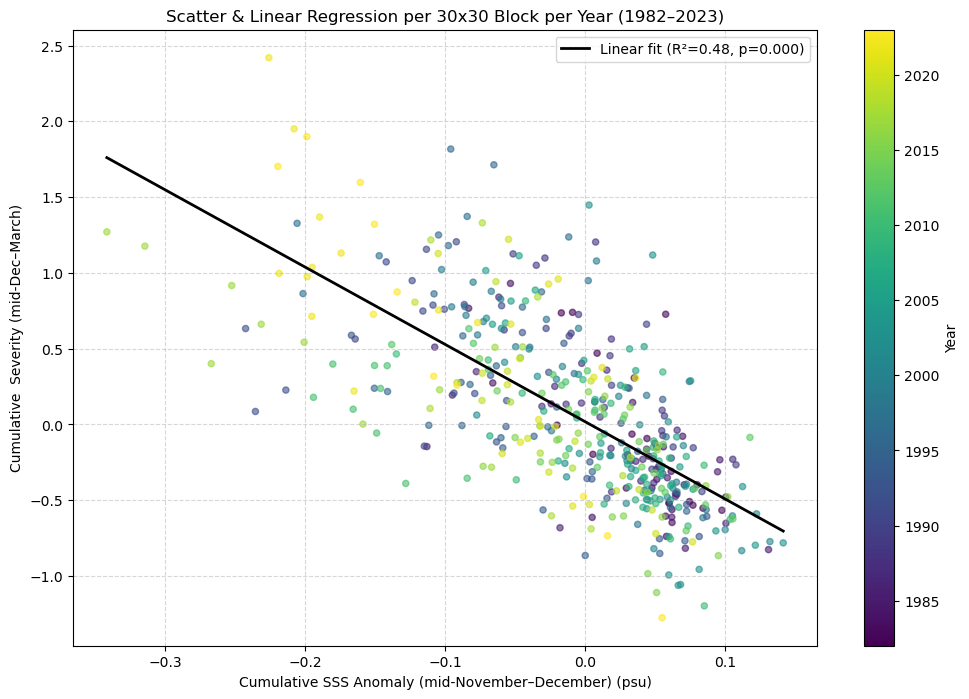

Linear Regression Results (After IQR outlier removal):
Slope: -5.0959
Intercept: 0.0186
R²: 0.4842
p-value: 3.9454e-68
Spearman rho: -0.7368, p-value: 3.1379e-80


In [ ]:
# This code used a more simple analysis, accounting for spatial autocorrelation in the data, where we looked at SIC anomalies prior to the MHW style events. Severity was used as a proxy for MHWs, as was SSTA.
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr
import matplotlib.cm as cm
import matplotlib.colors as mcolors
%matplotlib inline

# -----------------------------
# Parameters
# -----------------------------
block_size_lat = 30
block_size_lon = 30
years = np.arange(1982, 2024)

# -----------------------------
# Area-weighted block averaging function
# -----------------------------
def block_average_area_weighted(arr, area, block_size_lat, block_size_lon):
    arr = np.array(arr)
    weights = np.array(area)
    
    n_lat, n_lon = arr.shape
    n_blocks_lat = int(np.ceil(n_lat / block_size_lat))
    n_blocks_lon = int(np.ceil(n_lon / block_size_lon))

    result = np.zeros((n_blocks_lat, n_blocks_lon))
    
    for i in range(n_blocks_lat):
        for j in range(n_blocks_lon):
            # Determine slice for this block
            lat_start = i * block_size_lat
            lat_end = min((i + 1) * block_size_lat, n_lat)
            lon_start = j * block_size_lon
            lon_end = min((j + 1) * block_size_lon, n_lon)

            arr_block = arr[lat_start:lat_end, lon_start:lon_end]
            weights_block = weights[lat_start:lat_end, lon_start:lon_end]

            weighted_sum = np.sum(arr_block * weights_block)
            total_weight = np.sum(weights_block)

            result[i, j] = weighted_sum / total_weight

    return result

# -----------------------------
# Collect block-averaged values
# -----------------------------
x_list, y_list, year_list = [], [], []

lats = ts_severity['lat'].values  # Assuming your dataset has latitudes

for yr in years:
    severity = anomaly.sel(time=slice(f"{yr}-03-01", f"{yr}-05-31")).mean(dim="time").values
    sic = ts_severity.sel(time=slice(f"{yr}-01-01", f"{yr}-02-28")).mean(dim="time").values

    severity_block = block_average_area_weighted(severity, areas, block_size_lat, block_size_lon)
    sic_block = block_average_area_weighted(sic, areas, block_size_lat, block_size_lon)

    # Flatten and append
    x_list.append(severity_block.flatten())       # Predictor
    y_list.append(sic_block.flatten())  # Response
    year_list.append(np.full(sic_block.size, yr))
    
# Stack all years
x = np.concatenate(x_list)  # SIC anomaly
y = np.concatenate(y_list)  # Severity
years_flat = np.concatenate(year_list)

# Remove NaNs
mask = (~np.isnan(x)) & (~np.isnan(y))
x, y, years_flat = x[mask], y[mask], years_flat[mask]

if len(x) == 0 or len(y) == 0:
    raise ValueError("No valid data points left after masking NaNs. Check your input arrays.")

# -----------------------------
# Outlier removal using IQR (robust)
# -----------------------------
q25_x, q75_x = np.percentile(x, [25, 75])
iqr_x = q75_x - q25_x
q25_y, q75_y = np.percentile(y, [25, 75])
iqr_y = q75_y - q25_y
thresh = 3

mask_iqr = ((x >= q25_x - thresh*iqr_x) & (x <= q75_x + thresh*iqr_x) &
            (y >= q25_y - thresh*iqr_y) & (y <= q75_y + thresh*iqr_y))

x_clean = x[mask_iqr]
y_clean = y[mask_iqr]
years_clean = years_flat[mask_iqr]

print(f"Points before outlier removal: {len(x)}, after IQR clipping: {len(x_clean)}")

# -----------------------------
# Linear regression + Spearman correlation
# -----------------------------
slope, intercept, r_value, p_value, std_err = linregress(x, y)
rho, rho_p = spearmanr(x, y)

x_fit = np.linspace(x_clean.min(), x_clean.max(), 200)
y_fit = slope * x_fit + intercept

# -----------------------------
# Scatter plot colored by year
# -----------------------------
norm = mcolors.Normalize(vmin=years[0], vmax=years[-1])
cmap = cm.viridis
colors = cmap(norm(years_clean))

fig, ax = plt.subplots(figsize=(12,8))
sc = ax.scatter(x_clean, y_clean, alpha=0.6, s=20, color=colors)  # SIC on x, severity on y
ax.plot(x_fit, y_fit, color="black", lw=2,
        label=f"Linear fit (R²={r_value**2:.2f}, p={p_value:.3f})")
ax.set_xlabel("Cumulative SSS Anomaly (mid-November–December) (psu)")
ax.set_ylabel("Cumulative  Severity (mid-Dec–March)")
ax.set_title(f"Scatter & Linear Regression per {block_size_lat}x{block_size_lon} Block per Year (1982–2023)")
ax.grid(ls="--", alpha=0.5)
ax.legend()

# Colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Year')

plt.show()

# -----------------------------
# Print regression results
# -----------------------------
print("Linear Regression Results (After IQR outlier removal):")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R²: {r_value**2:.4f}")
print(f"p-value: {p_value:.4e}")
print(f"Spearman rho: {rho:.4f}, p-value: {rho_p:.4e}")


In [ ]:
## I tried using a linear learning model to see if it was able to predict the SIC later – it worked ok, but wasn't included
from sklearn.linear_model import TheilSenRegressor

# Pre-2016
reg_pre = TheilSenRegressor()
reg_pre.fit(x_pre.reshape(-1,1), y_pre)
slope_pre_robust = reg_pre.coef_[0]
intercept_pre_robust = reg_pre.intercept_

# Post-2016
reg_post = TheilSenRegressor()
reg_post.fit(x_post.reshape(-1,1), y_post)
slope_post_robust = reg_post.coef_[0]
intercept_post_robust = reg_post.intercept_


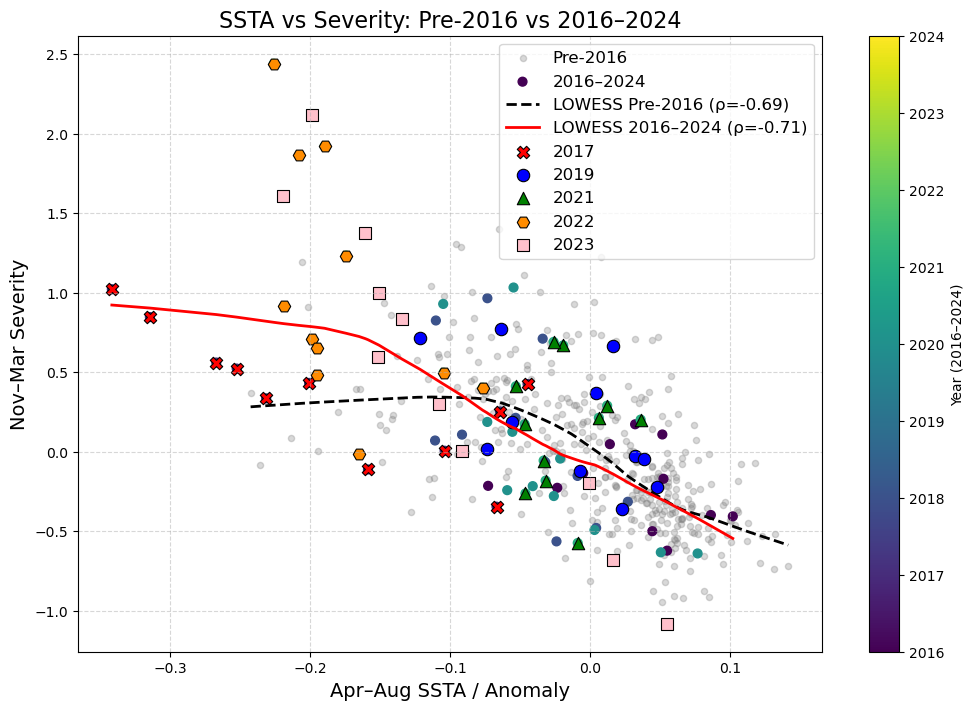

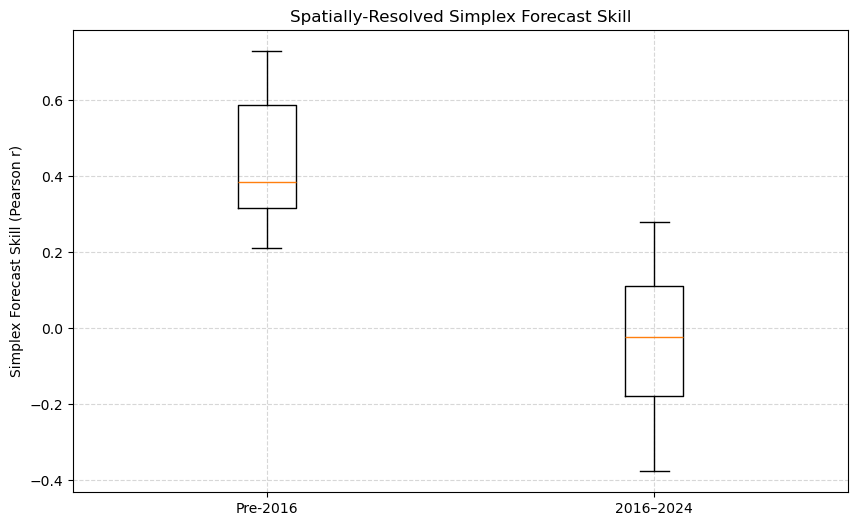

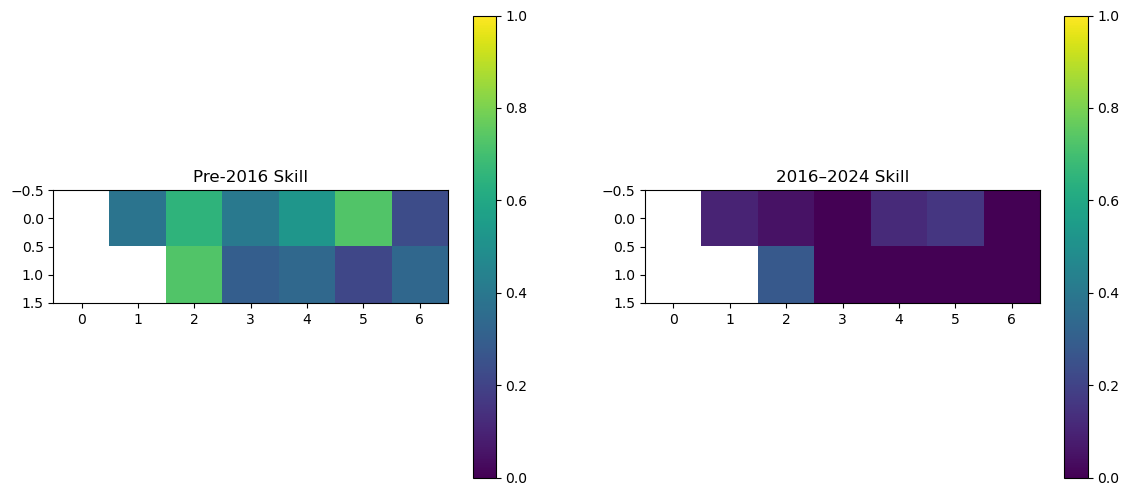

IndexError: boolean index did not match indexed array along dimension 2; dimension is 42 but corresponding boolean dimension is 112

In [ ]:
# These were extensive analyses that were initially included in the manuscript and analyses – but they are not used. Still, it provides some useful insight.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import statsmodels.api as sm
from scipy.stats import spearmanr

# -----------------------------
# 1. Flatten block-wise data for scatter plot
# -----------------------------
x_flat = x_blocked.reshape(-1, x_blocked.shape[2])
y_flat = y_blocked.reshape(-1, y_blocked.shape[2])
years_array = np.array(years)

# -----------------------------
# 2. Pre/post 2016 masks
# -----------------------------
mask_pre2016 = years_array < 2016
mask_post2016 = (years_array >= 2016) & (years_array <= 2024)

x_pre = x_blocked[:,:,mask_pre2016].reshape(-1)
y_pre = y_blocked[:,:,mask_pre2016].reshape(-1)
x_post = x_blocked[:,:,mask_post2016].reshape(-1)
y_post = y_blocked[:,:,mask_post2016].reshape(-1)
years_post = np.tile(years_array[mask_post2016], x_blocked.shape[0]*x_blocked.shape[1])

# Remove NaNs
mask_pre = (~np.isnan(x_pre)) & (~np.isnan(y_pre))
mask_post = (~np.isnan(x_post)) & (~np.isnan(y_post))
x_pre, y_pre = x_pre[mask_pre], y_pre[mask_pre]
x_post, y_post, years_post = x_post[mask_post], y_post[mask_post], years_post[mask_post]

# -----------------------------
# 3. LOWESS trends
# -----------------------------
lowess_pre = sm.nonparametric.lowess(y_pre, x_pre, frac=0.5)
lowess_post = sm.nonparametric.lowess(y_post, x_post, frac=0.5)

x_lowess_pre, y_lowess_pre = lowess_pre[:,0], lowess_pre[:,1]
x_lowess_post, y_lowess_post = lowess_post[:,0], lowess_post[:,1]

rho_pre, _ = spearmanr(x_pre, y_pre)
rho_post, _ = spearmanr(x_post, y_post)

# -----------------------------
# 4. Scatter plot with extreme years highlighted
# -----------------------------
fig, ax = plt.subplots(figsize=(12,8))

# Grey points for pre-2016
ax.scatter(x_pre, y_pre, color='grey', alpha=0.3, s=20, label='Pre-2016')

# Post-2016 points colored by year
norm = mcolors.Normalize(vmin=2016, vmax=2024)
cmap = cm.viridis
colors_post = cmap(norm(years_post))
ax.scatter(x_post, y_post, color=colors_post, s=40, label='2016–2024')

# LOWESS trends
ax.plot(x_lowess_pre, y_lowess_pre, color='black', lw=2, ls='--', label=f'LOWESS Pre-2016 (ρ={rho_pre:.2f})')
ax.plot(x_lowess_post, y_lowess_post, color='red', lw=2, ls='-', label=f'LOWESS 2016–2024 (ρ={rho_post:.2f})')

# Highlight extreme years
highlight_years = {2017:'X', 2019:'o', 2021:'^', 2022:'H', 2023:'s'}
highlight_colors = {2017:'red', 2019:'blue', 2021:'green', 2022:'darkorange', 2023:'pink'}
for yr, marker in highlight_years.items():
    mask_h = years_post == yr
    ax.scatter(x_post[mask_h], y_post[mask_h], color=highlight_colors[yr], s=80,
               marker=marker, edgecolors='black', linewidths=0.8, label=str(yr))

# Labels, title, grid
ax.set_xlabel("Apr–Aug SSTA / Anomaly", fontsize=14)
ax.set_ylabel("Nov–Mar Severity", fontsize=14)
ax.set_title("SSTA vs Severity: Pre-2016 vs 2016–2024", fontsize=16)
ax.grid(ls='--', alpha=0.5)
ax.legend(fontsize=12, loc='best')

# Colorbar for post-2016 years
smappable = cm.ScalarMappable(cmap=cmap, norm=norm)
smappable.set_array([])
cbar = plt.colorbar(smappable, ax=ax)
cbar.set_label("Year (2016–2024)")

plt.show()

# -----------------------------
# 5. Boxplots of block-wise Simplex skill
# -----------------------------
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot([skills_pre.flatten()[~np.isnan(skills_pre.flatten())],
            skills_post.flatten()[~np.isnan(skills_post.flatten())]],
           labels=['Pre-2016','2016–2024'])
ax.set_ylabel("Simplex Forecast Skill (Pearson r)")
ax.set_title("Spatially-Resolved Simplex Forecast Skill")
ax.grid(ls="--", alpha=0.5)
plt.show()

# -----------------------------
# 6. Spatial maps of skills
# -----------------------------
fig, axes = plt.subplots(1,2, figsize=(14,6))
im0 = axes[0].imshow(skills_pre, vmin=0, vmax=1, cmap='viridis')
axes[0].set_title('Pre-2016 Skill')
fig.colorbar(im0, ax=axes[0])
im1 = axes[1].imshow(skills_post, vmin=0, vmax=1, cmap='viridis')
axes[1].set_title('2016–2024 Skill')
fig.colorbar(im1, ax=axes[1])
plt.show()

# 5. Split pre/post 2016
# -----------------------------
# Assuming x_blocked, y_blocked have time dimension aligned with years_flat
mask_pre2016 = years_flat < 2016
mask_post2016 = (years_flat >= 2016) & (years_flat <= 2024)

x_pre_blocked = x_blocked[:,:,mask_pre2016]
y_pre_blocked = y_blocked[:,:,mask_pre2016]

x_post_blocked = x_blocked[:,:,mask_post2016]
y_post_blocked = y_blocked[:,:,mask_post2016]

skills_pre = compute_block_skills(x_pre_blocked, y_pre_blocked)
skills_post = compute_block_skills(x_post_blocked, y_post_blocked)

# -----------------------------
# 6. Summary statistics
# -----------------------------
print("Pre-2016 mean skill:", np.nanmean(skills_pre))
print("Pre-2016 skill std:", np.nanstd(skills_pre))
print("2016–2024 mean skill:", np.nanmean(skills_post))
print("2016–2024 skill std:", np.nanstd(skills_post))

# -----------------------------
# 7. Plot distribution of skills
# -----------------------------
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot([skills_pre.flatten()[~np.isnan(skills_pre.flatten())],
            skills_post.flatten()[~np.isnan(skills_post.flatten())]],
           labels=['Pre-2016', '2016–2024'])
ax.set_ylabel("Simplex Forecast Skill (Pearson r)")
ax.set_title("Spatially-Resolved Simplex Forecast Skill")
ax.grid(ls="--", alpha=0.5)
plt.show()

# -----------------------------
# Optional: plot spatial maps
# -----------------------------
fig, axes = plt.subplots(1,2, figsize=(14,6))
im0 = axes[0].imshow(skills_pre, vmin=0, vmax=1, cmap='viridis')
axes[0].set_title('Pre-2016 Skill')
fig.colorbar(im0, ax=axes[0])
im1 = axes[1].imshow(skills_post, vmin=0, vmax=1, cmap='viridis')
axes[1].set_title('2016–2024 Skill')
fig.colorbar(im1, ax=axes[1])
plt.show()


## Figure 10

Preparing data...
Data prepared successfully.

--- Computing correlations for lag 1 (March) ---
  -- Processing: Thermo. Vol. Tendency
  -- Processing: Growth

--- Computing correlations for lag 2 (April) ---
  -- Processing: Thermo. Vol. Tendency
  -- Processing: Growth

--- All computations complete. Generating final 2x2 styled figure. ---


  plt.tight_layout(rect=[0.02, 0.02, 1, 0.88])



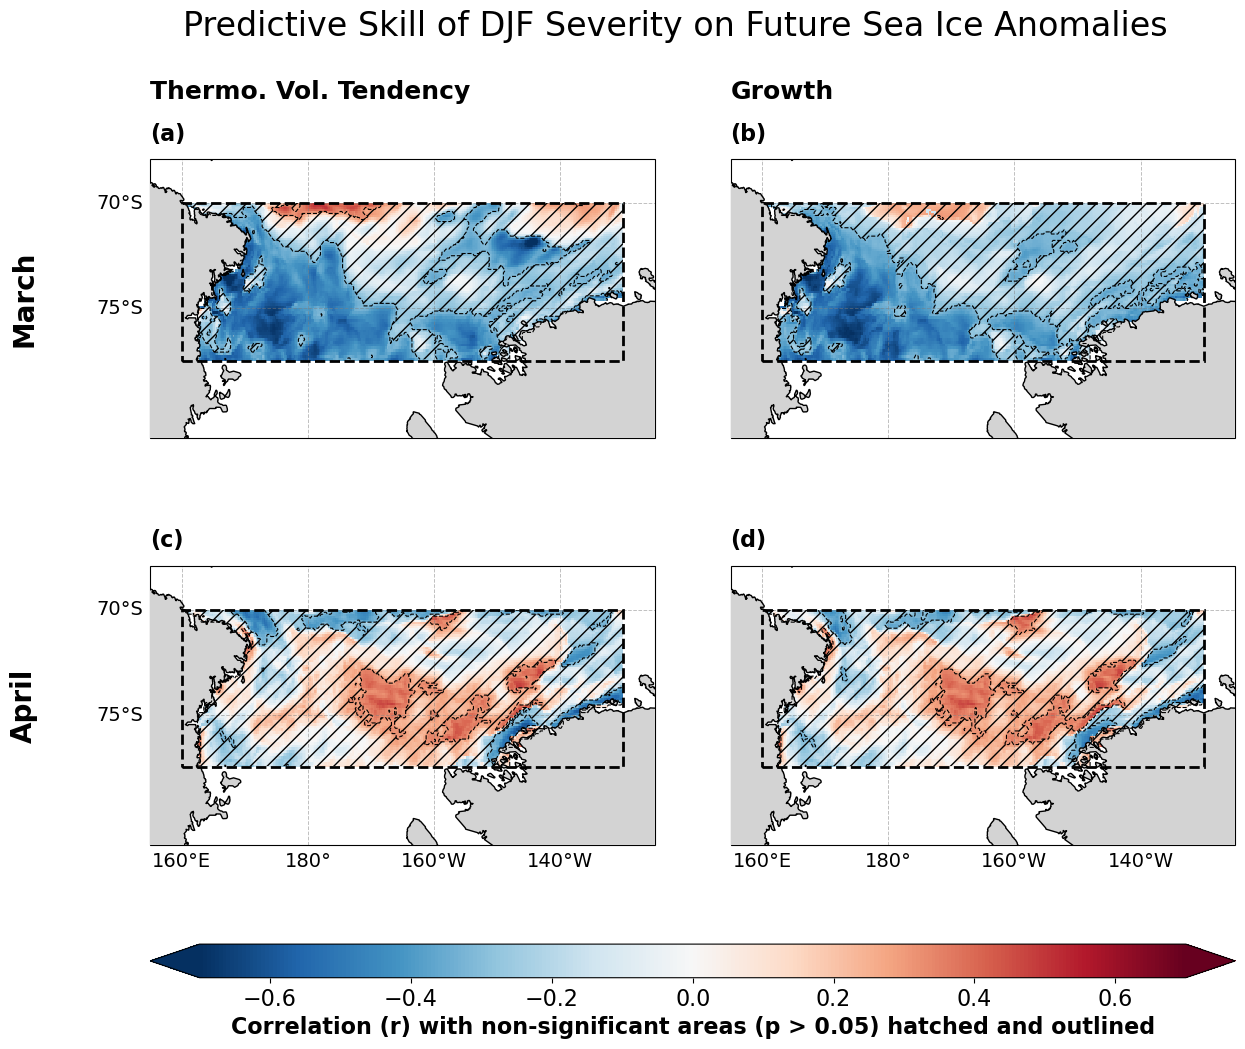


Analysis complete.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import xarray as xr
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import matplotlib.ticker as mticker

# -----------------------------
# CONFIGURATION
# -----------------------------
# Lags at which to test predictability (1 and 2 months after DJF)
lags_to_test = [1, 2]

# Years included in the analysis (DJF 1982 → 2022)
analysis_years = np.arange(1982, 2023)

# Minimum years required to compute regression at a grid cell
MIN_YEARS_FOR_STAT = 10

# Confidence threshold for statistical significance
SIGNIFICANCE_THRESHOLD = 0.95

# Default map projection centered around the Amundsen Sea region
CENTRAL_LONGITUDE = -160
PROJECTION = ccrs.Mercator(central_longitude=CENTRAL_LONGITUDE)

# Rectangle defining area of interest (Amundsen–Bellingshausen region),
# expressed in a longitude system centered around 180°.
RECT_LON_180 = (-200, -130)
RECT_LAT = (-77, -70)

# Padding for zoom box
PAD_LON = 5
PAD_LAT = 2.5

# Final zoomed map extent including extra padding
ZOOM_EXTENT = [
    RECT_LON_180[0] - PAD_LON,
    RECT_LON_180[1] + PAD_LON,
    RECT_LAT[0] - PAD_LAT,
    RECT_LAT[1] + PAD_LAT
]

# Land color for background
LAND_COLOR = 'lightgray'

# Global font settings for publication-quality output
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12

# -----------------------------
# FUNCTIONS
# -----------------------------
def compute_regression_skill(X, Y):
    """
    Computes regression statistics (r-value and significance) between DJF severity (X)
    and future sea ice anomaly (Y), gridcell-by-gridcell.
    
    Parameters
    ----------
    X, Y : np.ndarray
        Arrays of shape (lat, lon, years)
    
    Returns
    -------
    r_values : 2D array
        Correlation coefficients for each grid cell.
    significance : 2D array
        1 - p-value, representing the confidence level of correlation.
    """
    n_lat, n_lon, _ = Y.shape
    
    # Preallocate with NaNs
    p_values = np.full((n_lat, n_lon), np.nan)
    r_values = np.full((n_lat, n_lon), np.nan)
    
    # Loop over every grid cell
    for i in range(n_lat):
        for j in range(n_lon):
            x_series, y_series = X[i, j, :], Y[i, j, :]
            mask = ~np.isnan(x_series) & ~np.isnan(y_series)

            # Must have enough valid years to compute regression
            if np.sum(mask) < MIN_YEARS_FOR_STAT:
                continue

            x_clean = x_series[mask]
            y_clean = y_series[mask]

            # Skip if variance is too small (constant values)
            if np.var(x_clean) < 1e-10 or np.var(y_clean) < 1e-10:
                continue

            # Perform linear regression
            res = linregress(x_clean, y_clean)
            p_values[i, j] = res.pvalue
            r_values[i, j] = res.rvalue

    # Convert p-values to significance levels
    return r_values, 1.0 - p_values


def plot_publishable_figure(all_results, lons, lats, datasets_to_plot):
    """
    Creates a 2 × 2 figure showing predictive skill maps for:
    - Two future months (lags 1 and 2)
    - Two predictor datasets (Thermo. Vol. Tendency, Growth)
    
    Includes:
      • Clipping to region
      • Hatching of nonsignificant correlations
      • Panel labels
      • Consistent colorbar and layout
    
    Parameters
    ----------
    all_results : dict
        Nested dictionary containing correlation and significance arrays.
    lons, lats : 1D arrays
        Grid coordinate vectors.
    datasets_to_plot : list
        Names of datasets to show in columns.
    """
    num_rows = len(lags_to_test)
    num_cols = len(datasets_to_plot)

    # Create full figure + GridSpec layout
    fig = plt.figure(figsize=(14, 11))
    gs = GridSpec(
        num_rows + 1, num_cols, figure=fig,
        height_ratios=[1] * num_rows + [0.1],
        hspace=0.3, wspace=0.15
    )

    # Create one axes per panel
    axes = [
        [fig.add_subplot(gs[r, c], projection=PROJECTION) for c in range(num_cols)]
        for r in range(num_rows)
    ]

    panel_labels = ['(a)', '(b)', '(c)', '(d)']
    last_im = None  # Keep last colormap reference for use in colorbar

    for row_idx, lag in enumerate(lags_to_test):

        # Human-readable month (March for lag 1, April for lag 2)
        target_month_date = pd.to_datetime('2000-03-01') + pd.DateOffset(months=lag - 1)
        month_name = target_month_date.strftime('%B')

        for col_idx, title in enumerate(datasets_to_plot):
            ax = axes[row_idx][col_idx]
            ax.set_facecolor('white')

            # Extract correlation + significance data
            corr_data = all_results[lag][title]['corr']
            sig_data = all_results[lag][title]['sig']

            # Add cyclic point to avoid longitudinal seam
            data_cyclic, lon_cyclic = cutil.add_cyclic_point(corr_data, coord=lons)
            lon_grid, lat_grid = np.meshgrid(lon_cyclic, lats)

            # Plot correlation map
            im = ax.pcolormesh(
                lon_grid, lat_grid, data_cyclic, cmap='RdBu_r',
                vmin=-0.7, vmax=0.7, shading='auto',
                transform=ccrs.PlateCarree()
            )
            last_im = im

            # Draw region rectangle and clip data to it
            rect = Rectangle(
                (RECT_LON_180[0], RECT_LAT[0]),
                RECT_LON_180[1] - RECT_LON_180[0],
                RECT_LAT[1] - RECT_LAT[0],
                linewidth=2.0, edgecolor='black', facecolor='none',
                linestyle='--', transform=ccrs.PlateCarree(), zorder=10
            )
            ax.add_patch(rect)
            im.set_clip_path(rect)

            # Mask for nonsignificant points
            low_sig_mask = sig_data < SIGNIFICANCE_THRESHOLD
            mask_cyclic, _ = cutil.add_cyclic_point(low_sig_mask, coord=lons)

            # Hatch nonsignificant areas
            ax.contourf(
                lon_grid, lat_grid, mask_cyclic, levels=[0.5, 1.5],
                colors='none', hatches=['//'],
                transform=ccrs.PlateCarree(), zorder=7
            ).set_clip_path(rect)

            # Outline nonsignificant regions
            ax.contour(
                lon_grid, lat_grid, mask_cyclic, levels=[0.5],
                colors='black', linestyles='--', linewidths=0.8,
                transform=ccrs.PlateCarree(), zorder=8
            ).set_clip_path(rect)

            # Add y-axis label: only left column
            if col_idx == 0:
                ax.text(
                    -0.25, 0.5, month_name, transform=ax.transAxes,
                    rotation=90, fontsize=20, fontweight='bold',
                    va='center', ha='center'
                )

            # Set map extent and add land + coastlines
            ax.set_extent(ZOOM_EXTENT, crs=ccrs.PlateCarree())
            ax.add_feature(cfeature.LAND, zorder=5, facecolor=LAND_COLOR)
            ax.coastlines(zorder=6)

            # Gridlines formatting
            gl = ax.gridlines(
                draw_labels=True, dms=True, x_inline=False, y_inline=False,
                linewidth=0.7, color='gray', alpha=0.5, linestyle='--'
            )
            gl.top_labels = False
            gl.right_labels = False
            gl.left_labels = (col_idx == 0)
            gl.bottom_labels = (row_idx == num_rows - 1)

            # Custom tick positions
            gl.xlocator = mticker.FixedLocator([160, 180, -160, -140, -120])
            gl.ylocator = mticker.FixedLocator([-75, -70, -65])
            gl.xlabel_style = {'size': 14}
            gl.ylabel_style = {'size': 14}

    # Add column titles and panel labels
    for col_idx, title in enumerate(datasets_to_plot):
        ax_top = axes[0][col_idx]
        ax_bottom = axes[1][col_idx]

        ax_top.text(
            0.0, 1.2, title, transform=ax_top.transAxes,
            fontsize=18, fontweight='bold'
        )
        ax_top.text(
            0.0, 1.05, panel_labels[col_idx],
            transform=ax_top.transAxes, fontsize=16, fontweight='bold'
        )
        ax_bottom.text(
            0.0, 1.05, panel_labels[col_idx + num_cols],
            transform=ax_bottom.transAxes, fontsize=16, fontweight='bold'
        )

    # Colorbar under all panels
    if last_im:
        cax = fig.add_subplot(gs[-1, :])
        cbar = fig.colorbar(last_im, cax=cax, orientation='horizontal', extend='both')
        cbar.set_label(
            f'Correlation (r) with non-significant areas (p > {1 - SIGNIFICANCE_THRESHOLD:.2f}) hatched and outlined',
            fontsize=16, fontweight='bold'
        )
        cbar.ax.tick_params(labelsize=16)

    # Main figure title
    fig.suptitle(
        'Predictive Skill of DJF Severity on Future Sea Ice Anomalies',
        fontsize=24, y=0.99
    )

    plt.tight_layout(rect=[0.02, 0.02, 1, 0.88])

    # Save figure (publication-quality)
    fig.savefig(
        "/g/data/e14/ts7341/Figure_Code_For_Manuscript/mhw_delay_sea_ice.png",
        dpi=300, bbox_inches='tight'
    )
    plt.show()

# -----------------------------
# MAIN EXECUTION
# -----------------------------
if __name__ == '__main__':
    print("Preparing data...")

    try:
        # Attempt to load real climate data from memory (if previously defined)
        SSTa = ts_severity.sortby('time')
        datasets_to_analyze = {
            'Thermo. Vol. Tendency': anomaly_dvidtt.sortby('time'),
            'Growth': growth_anom.sortby('time')
        }

        # Extract 1D lon/lat coordinate arrays
        lons, lats = SSTa['lon'].values, SSTa['lat'].values
        print("Data prepared successfully.")

    except NameError:
        # If the real data are not present, create synthetic placeholder data
        print("Warning: Real data not found. Creating dummy data for demonstration.")

        times = pd.date_range("1982-01-01", "2023-12-31", freq='MS')
        lats = np.arange(-77, -67, 0.5)
        lons = np.arange(160, 240, 0.5)

        coords = {'time': times, 'lat': lats, 'lon': lons}
        dummy_data = np.random.randn(len(times), len(lats), len(lons))

        SSTa = xr.DataArray(dummy_data, coords=coords)

        datasets_to_analyze = {
            'Thermo. Vol. Tendency': xr.DataArray(dummy_data, coords=coords),
            'Growth': xr.DataArray(dummy_data, coords=coords)
        }

        lons, lats = SSTa['lon'].values, SSTa['lat'].values

    # Dictionary to store results for all lags and datasets
    all_results = {}

    for lag in lags_to_test:
        # Convert lag into a human-readable month
        target_month_date = pd.to_datetime('2000-03-01') + pd.DateOffset(months=lag - 1)
        target_month_name = target_month_date.strftime('%B')

        print(f"\n--- Computing correlations for lag {lag} ({target_month_name}) ---")

        results_for_lag = {}

        # Loop through predictor datasets
        for title, target_dataset in datasets_to_analyze.items():
            print(f"  -- Processing: {title}")

            djf_severity_maps = []      # DJF predictor values per year
            future_anomaly_maps = []    # Future outcome values per year

            # Loop through each analysis year
            for year in analysis_years:

                # DJF spans December (year) through February (year+1)
                djf_start = f"{year}-12-01"
                djf_end   = f"{year+1}-02-28"

                # Future anomaly month depends on lag
                target_date = pd.to_datetime(f"{year+1}-02-01") + pd.DateOffset(months=lag)

                try:
                    # Select DJF predictor values
                    djf_severity_period = SSTa.sel(time=slice(djf_start, djf_end))
                    if djf_severity_period.time.size < 3:
                        continue  # Ensure all three months exist

                    # Average DJF predictor across the 3-month season
                    mean_djf_severity = djf_severity_period.mean(dim='time').values

                    # Select future anomaly field
                    future_anomaly = target_dataset.sel(time=target_date, method='nearest').values

                    djf_severity_maps.append(mean_djf_severity)
                    future_anomaly_maps.append(future_anomaly)

                except (KeyError, IndexError):
                    continue  # Missing data → skip year

            # Stack valid years into time dimension and run regression
            if djf_severity_maps:
                X_yearly = np.stack(djf_severity_maps, axis=-1)
                Y_yearly = np.stack(future_anomaly_maps, axis=-1)

                corr_coeffs, regression_sig = compute_regression_skill(X_yearly, Y_yearly)

                results_for_lag[title] = {
                    'corr': corr_coeffs,
                    'sig': regression_sig
                }
            else:
                print(f"    No data for {title}. Skipping.")

        all_results[lag] = results_for_lag

    # Final figure generation
    if all_results:
        print("\n--- All computations complete. Generating final 2x2 styled figure. ---")
        plot_publishable_figure(all_results, lons, lats, list(datasets_to_analyze.keys()))
    else:
        print("\nNo results were computed. Cannot generate figure.")

    print("\nAnalysis complete.")


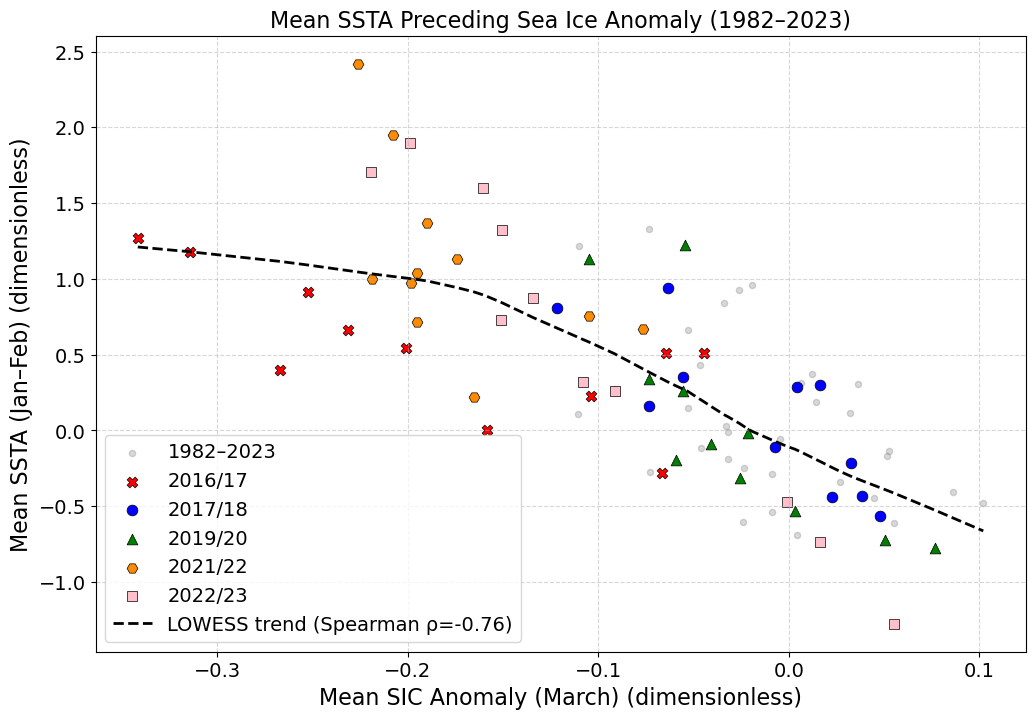

Spearman correlation: ρ = -0.7612, p-value = 7.4648e-18


In [ ]:
# This code was initially used to find some relationship between the severity and the anomaly in the SIC in March – was excluded from final manuscript!
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import statsmodels.api as sm
from scipy.stats import spearmanr

# -----------------------------
# LOWESS smoothing
# -----------------------------
lowess = sm.nonparametric.lowess(y_clean, x_clean, frac=0.5)
x_lowess, y_lowess = lowess[:, 0], lowess[:, 1]

# -----------------------------
# Spearman correlation
# -----------------------------
rho, rho_p = spearmanr(x_clean, y_clean)

# -----------------------------
# Plot
# -----------------------------
fig, ax = plt.subplots(figsize=(12,8))

# Masks for special years
mask_2017 = years_clean == 2017
mask_2018 = years_clean == 2019
mask_2020 = years_clean == 2020
mask_2022 = years_clean == 2022
mask_2023 = years_clean == 2023
mask_normal = ~(mask_2017 | mask_2018 | mask_2020 | mask_2022 | mask_2023)

# Plot all other years (grey dots)
ax.scatter(x_clean[mask_normal], y_clean[mask_normal],
           alpha=0.3, s=20, color="grey", label="1982–2023")

# Highlight 2017 with X (red)
ax.scatter(x_clean[mask_2017], y_clean[mask_2017],
           color="red", s=60, marker='X',
           edgecolors='black', linewidths=0.5, label='2016/17')

# Highlight 2018 with circle (blue)
ax.scatter(x_clean[mask_2018], y_clean[mask_2018],
           color="blue", s=60, marker='o',
           edgecolors='black', linewidths=0.5, label='2017/18')

# Highlight 2020 with triangle (green)
ax.scatter(x_clean[mask_2020], y_clean[mask_2020],
           color="green", s=60, marker='^',
           edgecolors='black', linewidths=0.5, label='2019/20')

# Highlight 2020 with triangle (green)
ax.scatter(x_clean[mask_2022], y_clean[mask_2022],
           color="darkorange", s=60, marker='H',
           edgecolors='black', linewidths=0.5, label='2021/22')

# Highlight 2020 with triangle (green)
ax.scatter(x_clean[mask_2023], y_clean[mask_2023],
           color="pink", s=60, marker='s',
           edgecolors='black', linewidths=0.5, label='2022/23')

# LOWESS trend
ax.plot(x_lowess, y_lowess, color="black", lw=2, ls="--",
        label=f"LOWESS trend (Spearman ρ={rho:.2f})")

# Labels & title
ax.set_xlabel("Mean SIC Anomaly (March) (dimensionless)", fontsize=16)
ax.set_ylabel("Mean SSTA (Jan–Feb) (dimensionless)", fontsize=16)
ax.set_title("Mean SSTA Preceding Sea Ice Anomaly (1982–2023)", fontsize=16)

# Tick size
ax.tick_params(axis='both', which='major', labelsize=14)

# Grid and legend
ax.grid(ls="--", alpha=0.5)
ax.legend(fontsize=14)

plt.show()

# -----------------------------
# Print Spearman result
# -----------------------------
print(f"Spearman correlation: ρ = {rho:.4f}, p-value = {rho_p:.4e}")